# Zillow's Home Value Prediction Exploratory Data Analysis

Source: https://www.kaggle.com/c/zillow-prize-1/overview

## Import Packages

In [551]:
# required packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from scipy import stats
color = sns.color_palette()

# tools
import glob
import pandas_profiling
import datetime
import warnings
import time
import gc
import numba as nb

# display set up
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 3)

## Functions Definition

In [552]:
# Timer decorator
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('----------------------')
            print('Function %r takes %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [553]:
# Resume table for quick dataframe examination 
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Missing %'] = 100 * df.isnull().sum().values / len(df)
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return(summary)

In [554]:
# Functions for memory reduction
@nb.jit()
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return(df)

---

In [555]:
glob.glob('*')

['~$zillow_data_dictionary.xlsx',
 'parsed_data.csv',
 'train_2017.csv',
 'Zillow Data Preparation.ipynb',
 'properties_2017.csv',
 'properties_2016.csv',
 'train_2016_v2.csv',
 'Zillow Modeling.ipynb',
 'df_mice_2016.csv',
 'df_mice_2017.csv',
 'Rplots.pdf',
 'zillow_data_dictionary.xlsx',
 'sample_submission.csv']

In [556]:
df_2016 = pd.read_csv('train_2016_v2.csv')
prop_2016 = pd.read_csv('properties_2016.csv')

df_2017 = pd.read_csv('train_2017.csv')
prop_2017 = pd.read_csv('properties_2017.csv')

### Target Dataset

In [557]:
df_prop_2016 = pd.merge(df_2016,prop_2016,how='inner',on='parcelid')
df_prop_2017 = pd.merge(df_2017,prop_2017,how='inner',on='parcelid')

In [558]:
df_prop_2016 = reduce_mem_usage(df_prop_2016)
df_prop_2017 = reduce_mem_usage(df_prop_2017)

Mem. usage decreased to 16.36 Mb (61.1% reduction)
Mem. usage decreased to 14.06 Mb (61.1% reduction)


In [559]:
df_prop_2016.shape, df_prop_2017.shape

((90275, 60), (77613, 60))

The target variable in this competition is the `logerror` term. Let's first do some visualization.

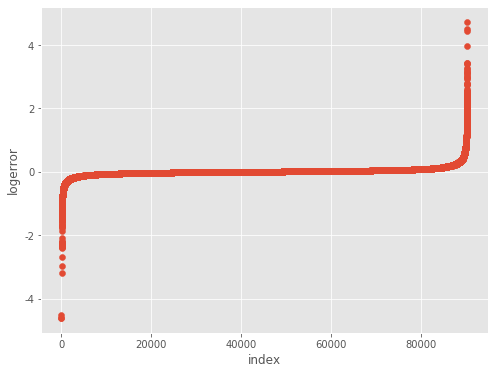

In [560]:
plt.figure(figsize=(8,6))
plt.scatter(range(df_prop_2016.shape[0]), np.sort(df_prop_2016.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

We can clearly see that there are some outliers at both end. This is the target variable that we are going to predict. Let's now leave it here and take a look at the property dataset.

### Property Dataset

In [562]:
resume = resumetable(df_prop_2016)
resume

Dataset Shape: (90275, 60)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,parcelid,int32,0,0.000,90150,11016594,14366692,12098116,16.46
1,logerror,float16,0,0.000,1890,0.0276,-0.168,-0.004,8.31
2,transactiondate,object,0,0.000,352,2016-01-01,2016-01-01,2016-01-01,7.84
3,airconditioningtypeid,float16,61494,68.119,6,1,NaN,1,0.43
4,architecturalstyletypeid,float16,90014,99.711,6,NaN,NaN,NaN,0.92
5,basementsqft,float16,90232,99.952,39,NaN,NaN,NaN,5.22
6,bathroomcnt,float16,0,0.000,23,2,3.5,3,2.45
7,bedroomcnt,float16,0,0.000,17,3,4,2,2.18
8,buildingclasstypeid,float16,90259,99.982,1,NaN,NaN,NaN,0.00
9,buildingqualitytypeid,float16,32911,36.456,8,4,NaN,4,1.38


In [563]:
name_list = list(resume.Name)
name_list

['parcelid',
 'logerror',
 'transactiondate',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'fireplaceflag',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'censustractandblock']

In [564]:
@timeit
def mappingfunc(series, mapping, na_string=False):
    mapped = series.map(mapping, na_action='ignore')
    if na_string:
        mapped = mapped.fillna(value = na_string)
    print(mapped.value_counts())
    print('-------------------')
    if mapped.isna().sum() != 0:
        print(f'{mapped.isna().sum() / len(series) * 100}% of values are still NaN.')
    else:
        print('There is no missing values in this series anymore.')
    return(mapped)

### Air Conditioning

From the data dictionary file we can see that missing values imply that there is no cooling system in the house. Therefore, we can simply impute **None** that means no air conditioning. Since this is a pure categorical variable, for explanability, let's also decode the number into its actual type of air conditioning system.

In [565]:
resume.query(f'Name == "{name_list[3]}"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
3,airconditioningtypeid,float16,61494,68.119,6,1,NaN,1,0.43


In [566]:
df_prop_2016.airconditioningtypeid.value_counts()

1.0     26668
13.0     1833
5.0       215
11.0       63
9.0         1
3.0         1
Name: airconditioningtypeid, dtype: int64

In [567]:
df_prop_2017.airconditioningtypeid.value_counts()

1.0     23186
13.0     1575
5.0       167
11.0       53
9.0        26
Name: airconditioningtypeid, dtype: int64

In [568]:
mapping = {1.0: 'Central', 3.0: 'Evaporative Cooler', 5.0: np.nan, 9.0: 'Refrigeration',
          11.0: 'Wall Unit', 12.0: 'Window Unit', 13.0: 'Unknown Type'}

df_prop_2016.airconditioningtypeid = mappingfunc(df_prop_2016.airconditioningtypeid, mapping, 'No Airconditioning')
df_prop_2017.airconditioningtypeid = mappingfunc(df_prop_2017.airconditioningtypeid, mapping, 'No Airconditioning')

No Airconditioning    61709
Central               26668
Unknown Type           1833
Wall Unit                63
Evaporative Cooler        1
Refrigeration             1
Name: airconditioningtypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 21.52 ms
No Airconditioning    52773
Central               23186
Unknown Type           1575
Wall Unit                53
Refrigeration            26
Name: airconditioningtypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 16.10 ms


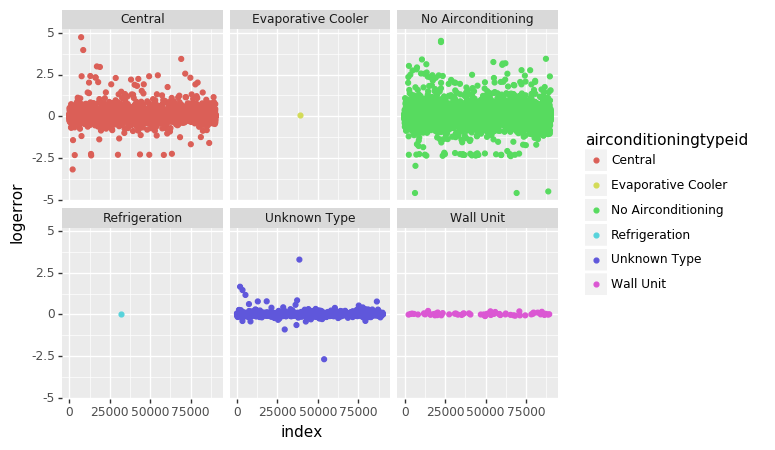

<ggplot: (7213052197)>

In [569]:
df_prop_2016['index'] = range(df_prop_2016.shape[0])

ggplot() + geom_point(mapping=aes(x = 'index', y = 'logerror', color = 'airconditioningtypeid'), data=df_prop_2016) + \
facet_wrap(facets='airconditioningtypeid')

**Fun Facts**:

1. Most of the data point have logerror values close to zero. For example, **Refrigeration, Evaporative Cooler, and Wall Unit**.

2. Two types of air conditioning system, **Central and No Airconditioning**, tend to have more errors.

3. For **Unknown Types**, it tends to be in the middle.

Here let's encode it into three types: **Central**, **No Airconditioning**, **Unknown Type**, and **Others**.

In [570]:
# mapping = {'Central': 'Central', 'Evaporative Cooler': "Others", 'Refrigeration': "Others",
#           'Wall Unit': "Others", 'Window Unit': "Others", 'Unknown Type': "Unknown Type", 
#            "No Airconditioning": "No Airconditioning"}

# df_prop_2016.airconditioningtypeid = mappingfunc(df_prop_2016.airconditioningtypeid, mapping)
# df_prop_2017.airconditioningtypeid = mappingfunc(df_prop_2017.airconditioningtypeid, mapping)

In [571]:
cat_list = []
cat_list.append('airconditioningtypeid')

---
### Transaction Date

In [572]:
resume.query(f'Name == "{name_list[2]}"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
2,transactiondate,object,0,0.0,352,2016-01-01,2016-01-01,2016-01-01,7.84


For transaction date, let's see the relationship bewteen log error and transaction date.

In [573]:
# convert strings to date object
df_prop_2016.transactiondate = df_prop_2016.transactiondate.apply(lambda x: pd.to_datetime(x))
df_prop_2017.transactiondate = df_prop_2017.transactiondate.apply(lambda x: pd.to_datetime(x))

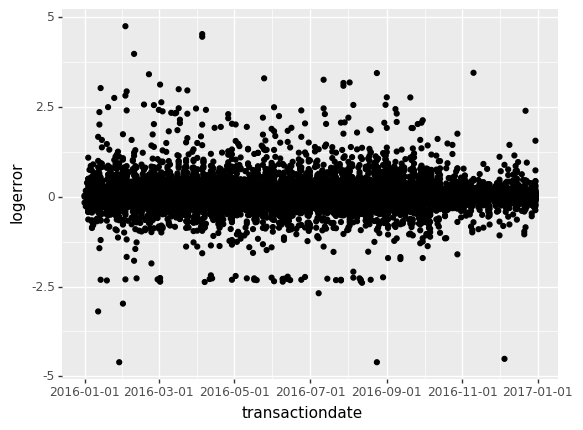

<ggplot: (7120381789)>

In [574]:
ggplot(aes(x = 'transactiondate', y = 'logerror'), data=df_prop_2016) + geom_point()

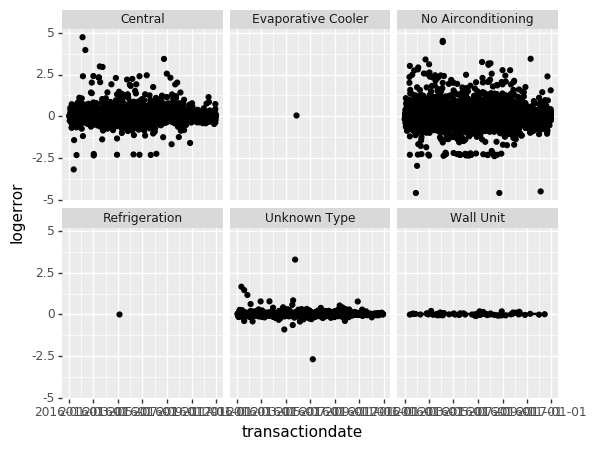

<ggplot: (7223718717)>

In [575]:
ggplot(aes(x = 'transactiondate', y = 'logerror'), data=df_prop_2016) + geom_point() + \
facet_wrap(facets='airconditioningtypeid') + geom_smooth(method='lm')

We can't see much different compared to previous plot. This is because in reality this dataframe is somewhat ordered by the transaction datetime. That is, the order of index is the same as the order of transaction datetime. Thus, the plot looks the same. Also here we add a regression line onto the plot. We can see that for all airconditioning type, transaction time has no relationship with logerror.

---
### Architectural Style Type

In [576]:
resume.query(f'Name == "{name_list[4]}"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
4,architecturalstyletypeid,float16,90014,99.711,6,NaN,NaN,NaN,0.92


In [577]:
df_prop_2016.architecturalstyletypeid.value_counts()

7.0     221
8.0      16
2.0      11
21.0      8
3.0       4
10.0      1
Name: architecturalstyletypeid, dtype: int64

In [578]:
df_prop_2017.architecturalstyletypeid.value_counts()

7.0     173
8.0      19
21.0      7
2.0       5
3.0       3
Name: architecturalstyletypeid, dtype: int64

In [579]:
mapping = {2.0: 'Bungalow', 3.0: 'Cape Cod', 7.0: 'Contemporary', 8.0: 'Conventional',
          10.0: 'French Provincial', 21.0: 'Ranch/Rambler'}

df_prop_2016.architecturalstyletypeid = mappingfunc(df_prop_2016.architecturalstyletypeid, mapping, 'MissingValue')
df_prop_2017.architecturalstyletypeid = mappingfunc(df_prop_2017.architecturalstyletypeid, mapping, 'MissingValue')

MissingValue         90014
Contemporary           221
Conventional            16
Bungalow                11
Ranch/Rambler            8
Cape Cod                 4
French Provincial        1
Name: architecturalstyletypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 19.04 ms
MissingValue     77406
Contemporary       173
Conventional        19
Ranch/Rambler        7
Bungalow             5
Cape Cod             3
Name: architecturalstyletypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 17.02 ms


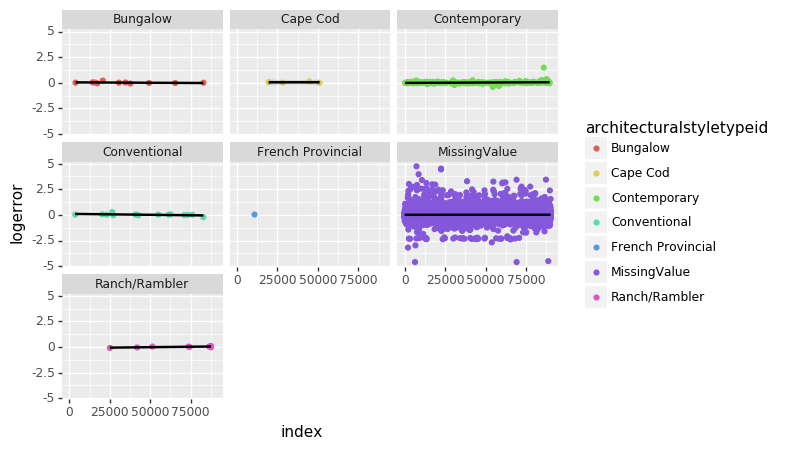

<ggplot: (7120370717)>

In [580]:
ggplot(aes(x = 'index', y = 'logerror', color = 'architecturalstyletypeid'), data=df_prop_2016) + geom_point() + \
facet_wrap(facets='architecturalstyletypeid') + geom_smooth(color = 'black', method = 'lm')

In this column we can get some insights.

There are lots of missing values here (~99.7%). So practically one good method is to drop this column. However, we can see that is the architectural style is missing, the logerror metrics tend to fluctuate quite a lot. When this style is set, it tends to be somewhat close to zero. Therefore, we can probably say that missing this value can cause huge discretion beteen the prediction and the actual sales price, thus making the range of logerror expand.

For now, since there's too many missing values, let's put it into our drop list.

In [581]:
drop_list = []
drop_list.append('architecturalstyletypeid')


---
### Basement Square Feet

In [582]:
resume.query(f'Name == "{name_list[5]}"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
5,basementsqft,float16,90232,99.952,39,NaN,NaN,NaN,5.22


Let's see the relationship bewteen basementsqft and logerror

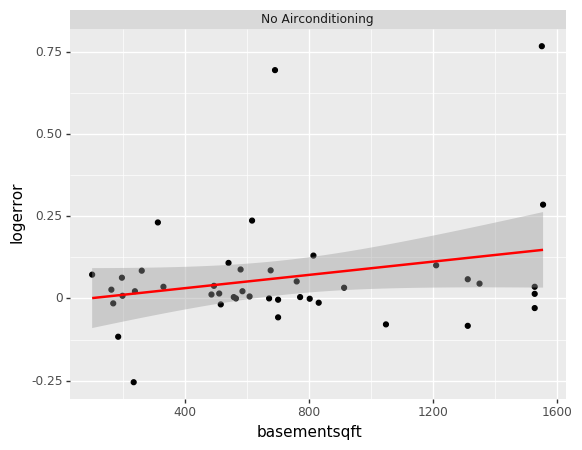

<ggplot: (7093510453)>

In [583]:
ggplot(aes(x = 'basementsqft', y = 'logerror'), data=df_prop_2016[df_prop_2016.basementsqft.notna()]) + \
geom_point() + geom_smooth(method = 'lm', color='red') + facet_wrap(facets = 'airconditioningtypeid')

**Fun facts**:

1. All the rooms with basementsqft stated are with no airconditioning! 


2. When the basement square feet gets larger, logerror tends to increase. That is, when basementsqft is small, Zestimate tends to fit the actual price bettet than the value is large. We can see when basementsqft increases, the logerror value also increases, showing that Zestimate tends to increase faster. We can say that **Zestimate may overestimate the importance of basement squared foot on actual sales price.**

It seems that this information is useful in our prediction. However, since there are too many missing values, it needs to be imputed before being used. Thus, let's add this into our inpute_list.


---
### Bathroom Count

In [584]:
resume.query(f'Name == "{name_list[6]}"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
6,bathroomcnt,float16,0,0.0,23,2,3.5,3,2.45


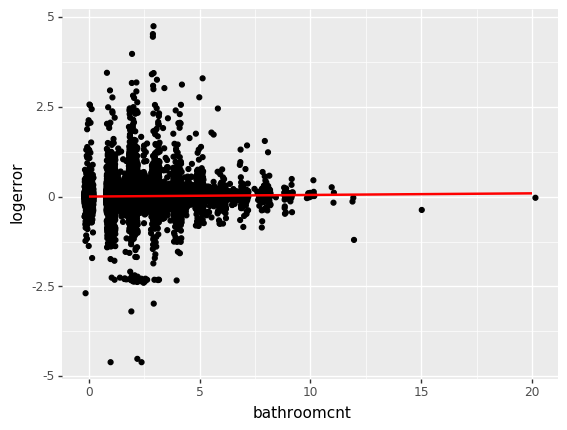

<ggplot: (7093510469)>

In [585]:
df_prop_2016.bathroomcnt = df_prop_2016.bathroomcnt.astype(float)
df_prop_2017.bathroomcnt = df_prop_2017.bathroomcnt.astype(float)

ggplot(aes(x = 'bathroomcnt', y = 'logerror'), data=df_prop_2016) + \
geom_jitter() + geom_smooth(color='red')

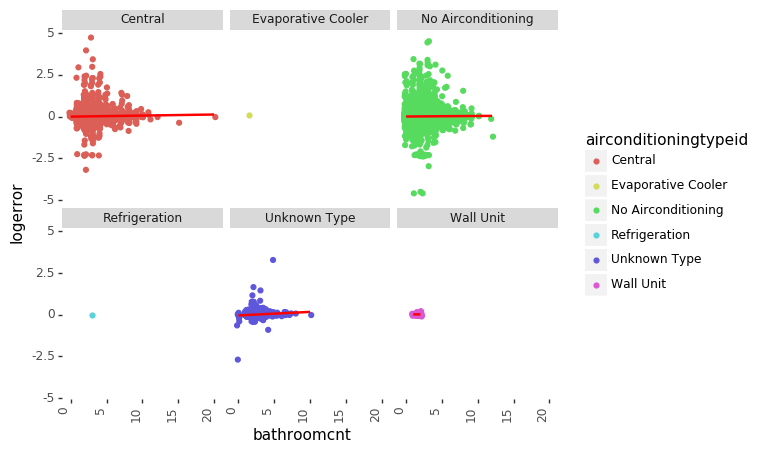

<ggplot: (7094963261)>

In [586]:
ggplot(aes(x = 'bathroomcnt', y = 'logerror', color='airconditioningtypeid'), data=df_prop_2016) + \
geom_jitter() + geom_smooth(color='red', method='lm') + facet_wrap(facets='airconditioningtypeid') + \
theme(panel_background=element_blank(), 
     axis_text_x = element_text(angle = 90, hjust = 1))

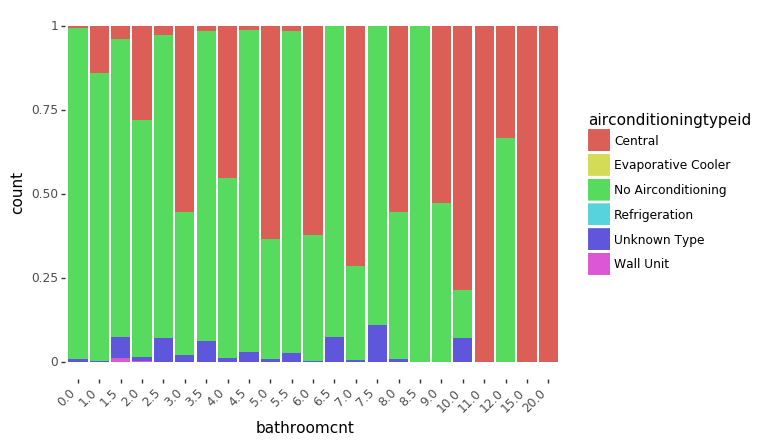

<ggplot: (7120042237)>

In [587]:
df_prop_2016.bathroomcnt = df_prop_2016.bathroomcnt.astype('str')
df_prop_2017.bathroomcnt = df_prop_2017.bathroomcnt.astype('str')

ggplot() + geom_bar(aes(x = 'bathroomcnt', fill='airconditioningtypeid'), data=df_prop_2016, position ='fill') + \
 theme(axis_text_x = element_text(angle = 45, hjust = 1), 
       panel_background=element_blank()) + \
scale_x_discrete(limits = ['0.0', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', 
                           '4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '7.0', 
                           '7.5', '8.0', '8.5', '9.0', '10.0', '11.0', '12.0', 
                           '15.0', '20.0'])

**Fun Facts**:

1. The logerror for lower bathroom count homes tend to fluctuate more compared to rooms with higher bathroom counts.

2. Rooms with more bathroom count tnds to be using the **Central** type of airconditioning, and rooms with less bathroom count tends to have **No Airconditioning**.

---
### Badroom Count

In [588]:
resume.query(f'Name == "{name_list[7]}"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
7,bedroomcnt,float16,0,0.0,17,3,4,2,2.18


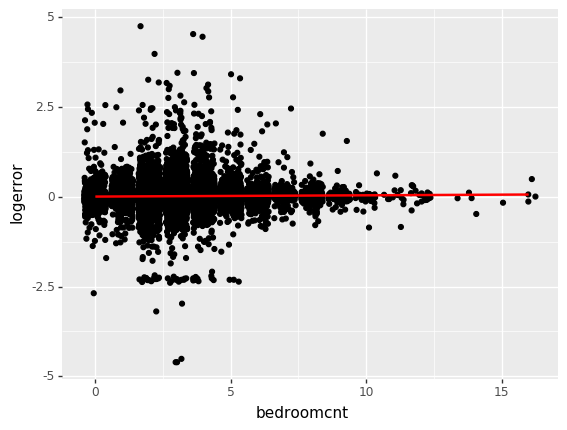

<ggplot: (7094964641)>

In [589]:
df_prop_2016.bedroomcnt = df_prop_2016.bedroomcnt.astype(float)
df_prop_2017.bedroomcnt = df_prop_2017.bedroomcnt.astype(float)

ggplot(aes(x = 'bedroomcnt', y = 'logerror'), data=df_prop_2016) + \
geom_jitter() + geom_smooth(color='red')

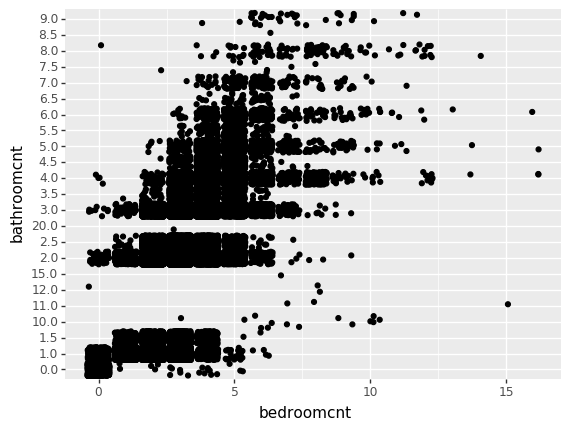

<ggplot: (7120055777)>

In [590]:
ggplot(aes(x = 'bedroomcnt', y = 'bathroomcnt'), data=df_prop_2016) + geom_jitter()

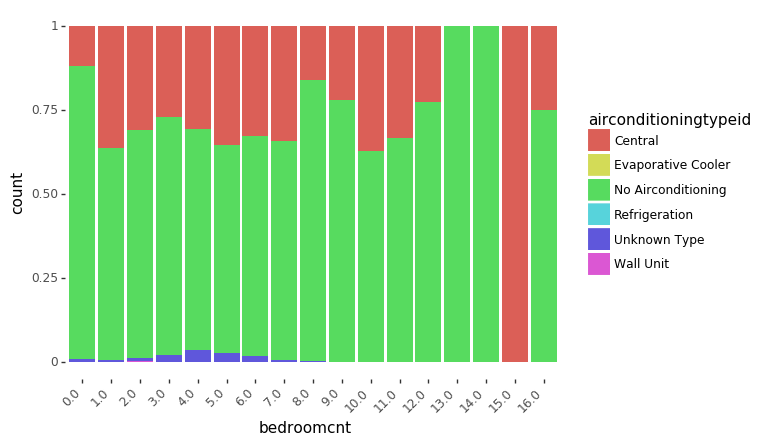

<ggplot: (7192784741)>

In [591]:
df_prop_2016.bedroomcnt = df_prop_2016.bedroomcnt.astype('str')
df_prop_2017.bedroomcnt = df_prop_2017.bedroomcnt.astype('str')

ggplot() + geom_bar(aes(x = 'bedroomcnt', fill='airconditioningtypeid'), data=df_prop_2016, position ='fill') + \
 theme(axis_text_x = element_text(angle = 45, hjust = 1), 
       panel_background=element_blank()) + \
scale_x_discrete(limits = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0',
                           '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0',
                           '14.0', '15.0', '16.0'])

**Fun Facts**:

1. Bedroom count has no relationship with type of air conditioning used.

2. The more bedroom, the more bathroom, which is quite reasonable.

Also both bedroom count and bathroom count have the same characteristic. There are some outliers for both of the feature. Here let's try to cap those outliers into at most 10.

In [592]:
df_prop_2016.bedroomcnt = df_prop_2016.bedroomcnt.astype(float)
df_prop_2016.bathroomcnt = df_prop_2016.bathroomcnt.astype(float)
df_prop_2016.loc[df_prop_2016.bedroomcnt > 10.0, 'bedroomcnt'] = 10.0
df_prop_2016.loc[df_prop_2016.bathroomcnt > 10.0, 'bathroomcnt'] = 10.0

df_prop_2017.bedroomcnt = df_prop_2017.bedroomcnt.astype(float)
df_prop_2017.bathroomcnt = df_prop_2017.bathroomcnt.astype(float)
df_prop_2017.loc[df_prop_2017.bedroomcnt > 10.0, 'bedroomcnt'] = 10.0
df_prop_2017.loc[df_prop_2017.bathroomcnt > 10.0, 'bathroomcnt'] = 10.0

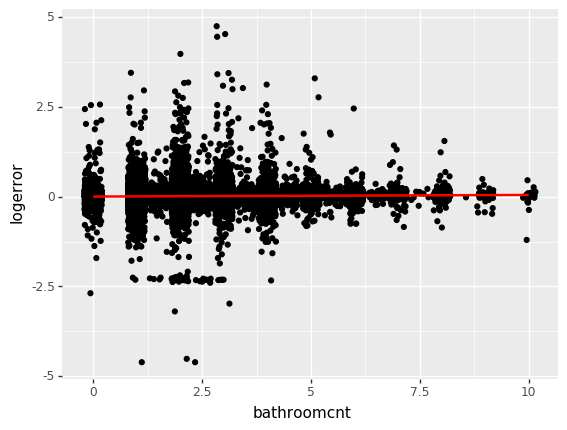

<ggplot: (7119854265)>

In [593]:
ggplot(aes(x = 'bathroomcnt', y = 'logerror'), data=df_prop_2016) + \
geom_jitter() + geom_smooth(color='red')

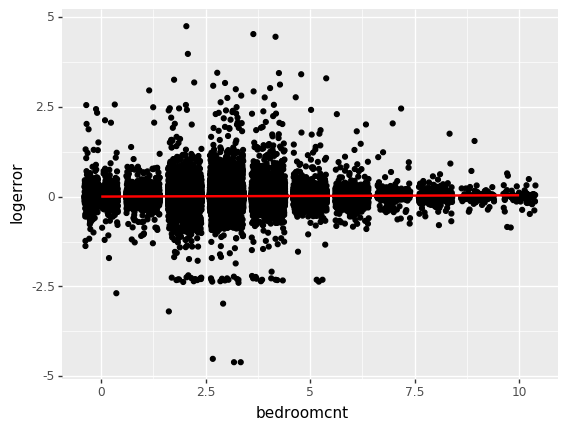

<ggplot: (7119860385)>

In [594]:
ggplot(aes(x = 'bedroomcnt', y = 'logerror'), data=df_prop_2016) + \
geom_jitter() + geom_smooth(color='red')

---

### Building Class Type

In [595]:
resume.query(f'Name == "{name_list[8]}"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
8,buildingclasstypeid,float16,90259,99.982,1,NaN,NaN,NaN,0.0


We can see that there are only one unique values, and with 99.982% missing. Let's see whether those non-missing values tells us something interesting.

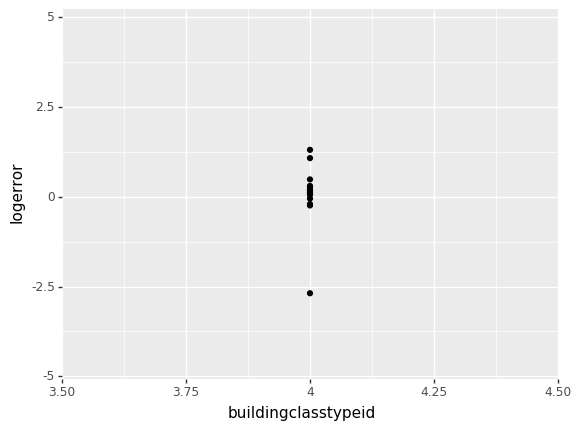

<ggplot: (7120002413)>

In [596]:
ggplot() + geom_point(aes(x='buildingclasstypeid', y='logerror'), data=df_prop_2016, na_rm=True) 

From the plot above we can see that there's nothing interested about this column. Thus, let's add it into the drop list.

In [597]:
drop_list.append('buildingclasstypeid')

---
### Building Quality Type

In [598]:
resume.query(f'Name == "{name_list[9]}"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
9,buildingqualitytypeid,float16,32911,36.456,8,4,NaN,4,1.38


In [599]:
df_prop_2016.buildingqualitytypeid.value_counts()

7.0     29310
4.0     23839
1.0      2627
10.0     1461
12.0      119
8.0         5
6.0         2
11.0        1
Name: buildingqualitytypeid, dtype: int64

In [600]:
df_prop_2017.buildingqualitytypeid.value_counts()

8.0     14685
6.0     13501
4.0      9508
7.0      5981
9.0      2303
5.0      2099
11.0      933
3.0       335
10.0      313
12.0      116
1.0        26
2.0         9
Name: buildingqualitytypeid, dtype: int64

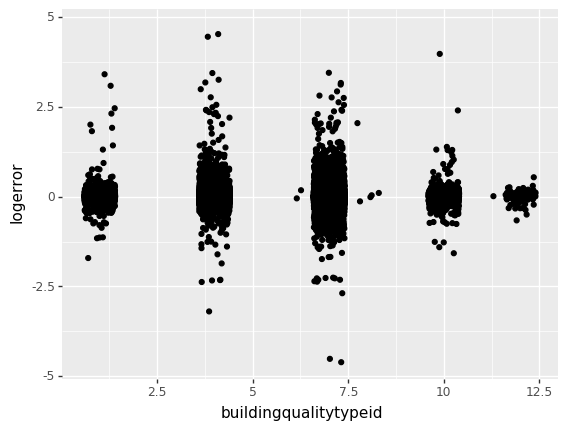

<ggplot: (7119994713)>

In [601]:
ggplot() + geom_jitter(aes(x = 'buildingqualitytypeid', y = 'logerror'), data=df_prop_2016, na_rm = True)

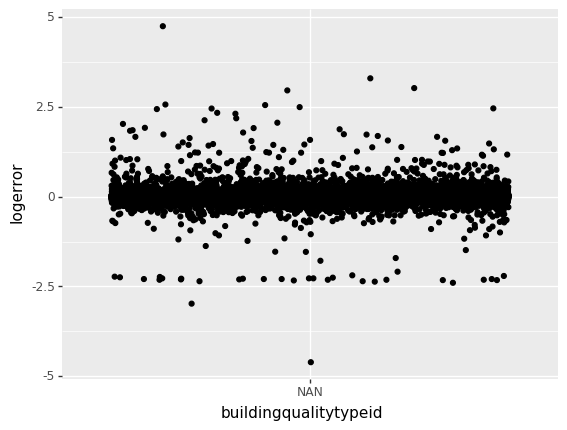

<ggplot: (7119933241)>

In [602]:
_ = df_prop_2016[df_prop_2016.buildingqualitytypeid.isna()].fillna('NAN')
ggplot() + geom_jitter(aes(x = 'buildingqualitytypeid', y = 'logerror'), data=_)

We can see that the relationship between building quality and logerror is almost undetectable. Though some building quaility type has larger range of logerror, they all basically center around 0.

From the data dictionary it states that this feature demonstrates the overall assessment of condition of the building from best (lowest) to worst (highest). That is, 1.0 is the best and 12.0 is the worst. Since there's no other information regarding how this feature can be used, let's treat it as a categorical value. 

In the meantime, we can see that some values have only little amount of data. Let's make it simply into 5 groups, putting 8.0 and 6.0 into 7.0 and 11.0, 12.0 into 10.0.

In [603]:
mapping = {1.0: 'best', 2.0: 'best', 3.0: 'best', 4.0: 'upper', 5.0: 'upper', 6.0: 'upper', 7.0: 'lower', 
           8.0: 'lower', 9.0: 'lower', 10.0: 'lowest', 11.0: 'lowest', 12.0: 'lowest'}

df_prop_2016.buildingqualitytypeid = mappingfunc(df_prop_2016.buildingqualitytypeid, mapping, 'MissingValue')
df_prop_2017.buildingqualitytypeid = mappingfunc(df_prop_2017.buildingqualitytypeid, mapping, 'MissingValue')

MissingValue    32911
lower           29315
upper           23841
best             2627
lowest           1581
Name: buildingqualitytypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 21.59 ms
MissingValue    27804
upper           25108
lower           22969
lowest           1362
best              370
Name: buildingqualitytypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 17.36 ms


In [604]:
cat_list.append('buildingqualitytypeid')

---
### Calculated Bath 

In the dictionary this feature has the same definition to bathroomcnt. Let's see what's the difference.

In [605]:
resume.query(f'Name == "{name_list[10]}"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
10,calculatedbathnbr,float16,1182,1.309,22,2,3.5,3,2.38


In [606]:
df_prop_2016[~(df_prop_2016.calculatedbathnbr == df_prop_2016.bathroomcnt)][['calculatedbathnbr','bathroomcnt']]

,calculatedbathnbr,bathroomcnt
126,NaN,0.0
174,NaN,0.0
231,NaN,0.0
293,NaN,0.0
299,NaN,0.0
...,...,...
89742,NaN,0.0
89752,NaN,0.0
89840,NaN,0.0
89895,NaN,0.0


We can see that Null value indicates 0.0. Here we can confidently drop this column.

In [607]:
drop_list.append('calculatedbathnbr')

---
### Deck Type

The definition of this feature: **Type of deck (if any) present on parcel**

In [608]:
resume.query(f'Name == "{name_list[11]}"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
11,decktypeid,float16,89617,99.271,1,NaN,NaN,NaN,0.0


In [609]:
df_prop_2016.decktypeid.value_counts()

66.0    658
Name: decktypeid, dtype: int64

In [610]:
df_prop_2017.decktypeid.value_counts()

66.0    614
Name: decktypeid, dtype: int64

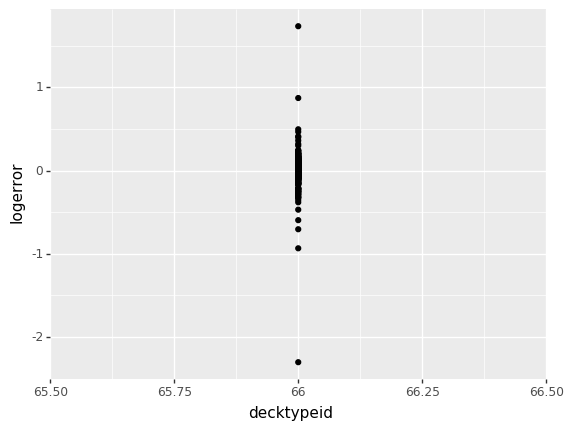

<ggplot: (7120072849)>

In [611]:
ggplot() + geom_point(aes(x = 'decktypeid', y = 'logerror'), data=df_prop_2016[df_prop_2016.decktypeid.notna()])

Still we can see there's not much information about this. Let's drop this feature.

In [612]:
drop_list.append('decktypeid')

---
### Square Fit

In [613]:
resume.iloc[12:19]

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
12,finishedfloor1squarefeet,float16,83419,92.405,1799,NaN,NaN,NaN,10.34
13,calculatedfinishedsquarefeet,float16,661,0.732,3408,1.68e+03,2.26e+03,2.22e+03,11.05
14,finishedsquarefeet12,float16,4679,5.183,3382,1.68e+03,2.26e+03,2.22e+03,11.03
15,finishedsquarefeet13,float16,90242,99.963,11,NaN,NaN,NaN,2.53
16,finishedsquarefeet15,float16,86711,96.052,1614,NaN,NaN,NaN,10.33
17,finishedsquarefeet50,float16,83419,92.405,1809,NaN,NaN,NaN,10.35
18,finishedsquarefeet6,float16,89854,99.534,347,NaN,NaN,NaN,8.33


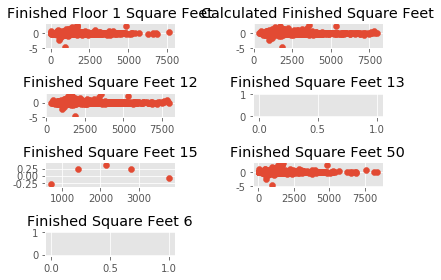

In [614]:
_ = df_prop_2016[df_prop_2016.finishedfloor1squarefeet.notna()]
plt.subplot(421)
plt.scatter(_.finishedfloor1squarefeet, _.logerror)
plt.title('Finished Floor 1 Square Feet')

plt.subplot(422)
plt.scatter(_.calculatedfinishedsquarefeet, _.logerror)
plt.title('Calculated Finished Square Feet')

plt.subplot(423)
plt.scatter(_.finishedsquarefeet12, _.logerror)
plt.title('Finished Square Feet 12')

plt.subplot(424)
plt.scatter(_.finishedsquarefeet13, _.logerror)
plt.title('Finished Square Feet 13')

plt.subplot(425)
plt.scatter(_.finishedsquarefeet15, _.logerror)
plt.title('Finished Square Feet 15')

plt.subplot(426)
plt.scatter(_.finishedsquarefeet50, _.logerror)
plt.title('Finished Square Feet 50')

plt.subplot(427)
plt.scatter(_.finishedsquarefeet6, _.logerror)
plt.title('Finished Square Feet 6')

plt.tight_layout()

---

### FIPS

Definition: **Federal Information Processing Standard code**

In [615]:
df_prop_2016.fips.value_counts()

6036.0    58574
6060.0    24505
6112.0     7196
Name: fips, dtype: int64

In [616]:
df_prop_2017.fips.value_counts()

6036.0    50696
6060.0    20631
6112.0     6252
Name: fips, dtype: int64

In [617]:
df_prop_2016.fips = df_prop_2016.fips.replace(6036.0,'Code1').replace(6060.0,'Code2').replace(6112.0,'Code3')
df_prop_2017.fips = df_prop_2017.fips.replace(6036.0,'Code1').replace(6060.0,'Code2').replace(6112.0,'Code3')

In [618]:
cat_list.append('fips')

---
### Fireplace Count

Definition: **Number of fireplaces in a home (if any)**

In [619]:
df_prop_2016.fireplacecnt.value_counts()

1.0    8165
2.0    1106
3.0     312
4.0      21
5.0       3
Name: fireplacecnt, dtype: int64

In [620]:
df_prop_2017.fireplacecnt.value_counts()

1.0    7018
2.0     998
3.0     235
4.0      35
5.0       3
Name: fireplacecnt, dtype: int64

In [621]:
df_prop_2016.fireplacecnt = df_prop_2016.fireplacecnt.replace(np.nan, 0)
df_prop_2017.fireplacecnt = df_prop_2017.fireplacecnt.replace(np.nan, 0)

---
### Fastforward EDA

In [622]:
resume

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,parcelid,int32,0,0.000,90150,11016594,14366692,12098116,16.46
1,logerror,float16,0,0.000,1890,0.0276,-0.168,-0.004,8.31
2,transactiondate,object,0,0.000,352,2016-01-01,2016-01-01,2016-01-01,7.84
3,airconditioningtypeid,float16,61494,68.119,6,1,NaN,1,0.43
4,architecturalstyletypeid,float16,90014,99.711,6,NaN,NaN,NaN,0.92
5,basementsqft,float16,90232,99.952,39,NaN,NaN,NaN,5.22
6,bathroomcnt,float16,0,0.000,23,2,3.5,3,2.45
7,bedroomcnt,float16,0,0.000,17,3,4,2,2.18
8,buildingclasstypeid,float16,90259,99.982,1,NaN,NaN,NaN,0.00
9,buildingqualitytypeid,float16,32911,36.456,8,4,NaN,4,1.38


In [623]:
resume[(resume['dtypes'] == np.float16) | (resume['dtypes'] == np.float32)].iloc[19:]

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
21,fullbathcnt,float16,1182,1.309,14,2,3,3,1.83
22,garagecarcnt,float16,60338,66.838,15,NaN,2,NaN,1.09
23,garagetotalsqft,float16,60338,66.838,870,NaN,468,NaN,6.27
25,heatingorsystemtypeid,float16,34195,37.879,12,2,NaN,2,1.14
26,latitude,float32,0,0.000,63620,3.43e+07,3.37e+07,3.41e+07,15.64
27,longitude,float32,0,0.000,57817,-1.18e+08,-1.18e+08,-1.18e+08,15.29
28,lotsizesquarefeet,float32,10150,11.243,20016,7.53e+03,3.64e+03,1.14e+04,13.23
29,poolcnt,float16,72374,80.171,1,NaN,NaN,NaN,0.00
30,poolsizesum,float16,89306,98.927,273,NaN,NaN,NaN,6.81
31,pooltypeid10,float16,89114,98.714,1,NaN,NaN,NaN,0.00


In [624]:
drop_list.extend(['fullbathcnt','censustractandblock','typeconstructiontypeid','assessmentyear'])

### Regional label

In this dataset there are lots of regional label. Since there are too many types, here I'll only use regionidcounty to represent to influece by region.

In [625]:
embed_list = []
embed_list.extend(['regionidcity','regionidzip', 'latitude','longitude','rawcensustractandblock'])
drop_list.extend(['regionidneighborhood'])

In [626]:
df_prop_2016.regionidcounty.value_counts()

3100.0    58574
1286.0    24505
2060.0     7196
Name: regionidcounty, dtype: int64

In [627]:
df_prop_2017.regionidcounty.value_counts()

3100.0    50696
1286.0    20631
2060.0     6252
Name: regionidcounty, dtype: int64

In [628]:
mapping = {3100.0: 'County1', 1286.0: 'County2', 2060.0: 'County3'}

df_prop_2016.regionidcounty = mappingfunc(df_prop_2016.regionidcounty, mapping)
df_prop_2017.regionidcounty = mappingfunc(df_prop_2017.regionidcounty, mapping, 'MissingValue')

County1    58574
County2    24505
County3     7196
Name: regionidcounty, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 13.77 ms
County1         50696
County2         20631
County3          6252
MissingValue       34
Name: regionidcounty, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 14.19 ms


In [629]:
cat_list.append('regionidcounty')

### Heating or System Type

In [630]:
df_prop_2016.heatingorsystemtypeid.value_counts()

2.0     38303
7.0     15519
24.0     1071
6.0       970
20.0       97
13.0       76
18.0       25
1.0        13
14.0        2
10.0        2
11.0        1
12.0        1
Name: heatingorsystemtypeid, dtype: int64

In [631]:
df_prop_2017.heatingorsystemtypeid.value_counts()

2.0     33633
7.0     14107
24.0      850
6.0       777
20.0      104
13.0       60
18.0       23
1.0        13
10.0        3
11.0        1
Name: heatingorsystemtypeid, dtype: int64

In [632]:
mapping = {1.0: 'Baseboard', 2.0: 'Central', 6.0: 'Forced air', 7.0: 'Floor/Wall', 10.0: 'Other', 11.0: 'Other',
           12.0: 'Other', 13.0: 'None', 14.0: 'Other', 18.0: 'Radiant', 20.0: 'Other', 24.0: 'Some Type'}

df_prop_2016.heatingorsystemtypeid = mappingfunc(df_prop_2016.heatingorsystemtypeid, mapping, 'MissingValue')
df_prop_2017.heatingorsystemtypeid = mappingfunc(df_prop_2017.heatingorsystemtypeid, mapping, 'MissingValue')

Central         38303
MissingValue    34195
Floor/Wall      15519
Some Type        1071
Forced air        970
Other             103
None               76
Radiant            25
Baseboard          13
Name: heatingorsystemtypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 20.05 ms
Central         33633
MissingValue    28042
Floor/Wall      14107
Some Type         850
Forced air        777
Other             108
None               60
Radiant            23
Baseboard          13
Name: heatingorsystemtypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 42.93 ms


In [633]:
cat_list.append('heatingorsystemtypeid')

### Property Land Use Type

In [634]:
df_prop_2016.propertylandusetypeid.value_counts()

261.0    60637
266.0    22815
246.0     2376
269.0     2334
248.0      879
247.0      629
265.0      356
263.0       84
260.0       62
275.0       46
267.0       28
31.0        17
264.0       11
47.0         1
Name: propertylandusetypeid, dtype: int64

In [635]:
df_prop_2017.propertylandusetypeid.value_counts()

261.0    52441
266.0    19342
246.0     2021
269.0     1947
248.0      729
247.0      539
265.0      335
263.0       74
275.0       59
260.0       42
267.0       29
31.0        15
264.0        6
Name: propertylandusetypeid, dtype: int64

In [636]:
mapping = {261.0: 'Single Family Residential', 266.0: 'Condominium', 246.0: 'Duplex', 
           269.0: 'Planned Unit Development', 248.0: 'Quadruplex', 247.0: 'Triplex', 
           265.0: 'Cluster Home', 263.0: 'Mobile Home', 260.0: 'Residential General', 
           275.0: 'Manufactured, Modular, Prefabricated Homes', 267.0: 'Cooperative',
           31.0: 'Commercial/Office/Residential Mixed Used', 264.0:'Townhouse', 
           47.0: 'Commercial/Office/Residential Mixed Used'}

df_prop_2016.propertylandusetypeid = mappingfunc(df_prop_2016.propertylandusetypeid, mapping, 'MissingValue')
df_prop_2017.propertylandusetypeid = mappingfunc(df_prop_2017.propertylandusetypeid, mapping, 'MissingValue')

Single Family Residential                     60637
Condominium                                   22815
Duplex                                         2376
Planned Unit Development                       2334
Quadruplex                                      879
Triplex                                         629
Cluster Home                                    356
Mobile Home                                      84
Residential General                              62
Manufactured, Modular, Prefabricated Homes       46
Cooperative                                      28
Commercial/Office/Residential Mixed Used         18
Townhouse                                        11
Name: propertylandusetypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 19.63 ms
Single Family Residential                     52441
Condominium                                   19342
Duplex                                        

In [637]:
cat_list.append('propertylandusetypeid')

### Story Type

In [638]:
df_prop_2016.storytypeid.value_counts()

7.0    43
Name: storytypeid, dtype: int64

In [639]:
df_prop_2017.storytypeid.value_counts()

7.0    50
Name: storytypeid, dtype: int64

In [640]:
mapping = {7.0: 'Basement'}

df_prop_2016.storytypeid = mappingfunc(df_prop_2016.storytypeid, mapping, 'Not Basement')
df_prop_2017.storytypeid = mappingfunc(df_prop_2017.storytypeid, mapping, 'Not Basement')

Not Basement    90232
Basement           43
Name: storytypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 37.50 ms
Not Basement    77563
Basement           50
Name: storytypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 19.90 ms


In [641]:
cat_list.append('storytypeid')

### Pools

In [642]:
l = ['poolcnt','pooltypeid10','pooltypeid2','pooltypeid7']
for col in l:
    df_prop_2016[col] = df_prop_2016[col].apply(lambda x: 1 if x == 1 else 0)
    df_prop_2017[col] = df_prop_2017[col].apply(lambda x: 1 if x == 1 else 0)

In [643]:
ind = list(df_prop_2016[df_prop_2016.poolcnt == 0][['poolsizesum','poolcnt']].index) # those don't have pool
for i in ind:
    df_prop_2016.loc[i,'poolsizesum'] = 0

    
ind = list(df_prop_2017[df_prop_2017.poolcnt == 0][['poolsizesum','poolcnt']].index) # those don't have pool
for i in ind:
    df_prop_2017.loc[i,'poolsizesum'] = 0

In [644]:
cat_list.extend(['poolcnt','pooltypeid10','pooltypeid2','pooltypeid7'])

### Year Built

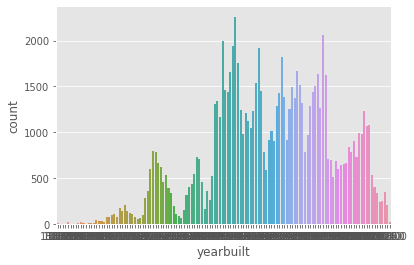

In [645]:
sns.countplot(df_prop_2016.yearbuilt)

In [646]:
print(f"The first year in this series: {df_prop_2016.yearbuilt.min()}")
print(f"The last year in this series: {df_prop_2016.yearbuilt.max()}")

The first year in this series: 1885.0
The last year in this series: 2015.0


In [647]:
print(f"The first year in this series: {df_prop_2017.yearbuilt.min()}")
print(f"The last year in this series: {df_prop_2017.yearbuilt.max()}")

The first year in this series: 1824.0
The last year in this series: 2016.0


Let's make it 13 years a bin. That is, there will be 10 bins.

In [648]:
df_prop_2016.yearbuilt = pd.cut(df_prop_2016.yearbuilt,bins = 10).astype(str) # convert into string object
df_prop_2017.yearbuilt = pd.cut(df_prop_2017.yearbuilt,bins = 10).astype(str) # convert into string object

In [649]:
cat_list.append('yearbuilt')

### Tax Delinquency Year

In [650]:
df_prop_2016.taxdelinquencyyear.value_counts()

14.0    628
15.0    518
13.0    210
12.0    154
10.0     89
11.0     85
9.0      63
8.0      24
7.0       8
6.0       3
99.0      1
Name: taxdelinquencyyear, dtype: int64

In [651]:
df_prop_2017.taxdelinquencyyear.value_counts()

15.0    1560
14.0     801
13.0     187
12.0     113
11.0      98
10.0      66
9.0       47
8.0       14
7.0       10
6.0        1
3.0        1
4.0        1
99.0       1
Name: taxdelinquencyyear, dtype: int64

Since there are too many missing values, let's make it a categorical value, 0 stating missing and 1 stating existing.

In [652]:
df_prop_2016.taxdelinquencyyear = df_prop_2016.taxdelinquencyyear.apply(lambda x: 0 if np.isnan(x) else 1)
df_prop_2017.taxdelinquencyyear = df_prop_2017.taxdelinquencyyear.apply(lambda x: 0 if np.isnan(x) else 1)

In [653]:
cat_list.append('taxdelinquencyyear')

---
### Object Datatype

In [654]:
resume[(resume['dtypes'] == object)]

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
2,transactiondate,object,0,0.000,352,2016-01-01,2016-01-01,2016-01-01,7.84
24,hashottuborspa,object,87910,97.380,1,NaN,NaN,NaN,0.00
34,propertycountylandusecode,object,1,0.001,77,0100,1,0100,3.20
36,propertyzoningdesc,object,31962,35.405,1996,LARS,NaN,PSR6,7.89
51,fireplaceflag,object,90053,99.754,1,NaN,NaN,NaN,0.00
57,taxdelinquencyflag,object,88492,98.025,1,NaN,NaN,NaN,0.00


### Has Hot Tub or Spa

Definition: **Does the home have a hot tub or spa**

In [655]:
df_prop_2016.hashottuborspa = df_prop_2016.hashottuborspa.replace(np.nan, 'No').replace(True, 'Yes')
df_prop_2017.hashottuborspa = df_prop_2017.hashottuborspa.replace(np.nan, 'No').replace(True, 'Yes')

In [656]:
df_prop_2016.hashottuborspa.value_counts()

No     87910
Yes     2365
Name: hashottuborspa, dtype: int64

In [657]:
df_prop_2017.hashottuborspa.value_counts()

No     76074
Yes     1539
Name: hashottuborspa, dtype: int64

In [658]:
cat_list.append('hashottuborspa')

### Property County Land Use Code

Definition: **County land use code i.e. it's zoning at the county level**

These are all categorical value. Let's make those minor use code into a new code **'Minor'**. Since there's only one missing value, we can also make it into this **'Minor'**.

In [659]:
len(df_prop_2016.propertycountylandusecode.value_counts()), len(df_prop_2017.propertycountylandusecode.value_counts())

(77, 75)

In [660]:
# l = list(df_prop_2016.propertycountylandusecode.value_counts()[23:].index)
# df_prop_2016['propertycountylandusecode'].fillna('Minor', inplace=True)
# for col in l:
#     df_prop_2016['propertycountylandusecode'].replace(col,'Minor',inplace=True)
    
# l = list(df_prop_2017.propertycountylandusecode.value_counts()[23:].index)
# df_prop_2017['propertycountylandusecode'].fillna('Minor', inplace=True)
# for col in l:
#     df_prop_2017['propertycountylandusecode'].replace(col,'Minor',inplace=True)

In [661]:
embed_list.append('propertycountylandusecode')

### Property Zoning Desc

Definition: **Description of the allowed land uses (zoning) for that property**

In [662]:
for i in df_prop_2016.propertyzoningdesc.unique():
    print(i)

LARS
nan
PSR6
LAR3
HBR3YY
CORH*
LARE9
LAR1
BUR1*
LBR4R
LBR1N
LMR1*
PDRPD6.6U*
LBR4N
SCUR2
PAR1YY
PSR2
LARE40
LCR18000*
POR16000*
SDSFH*
CCR2YY
INR4*
CVR17500*
LARD2
LARD1.5
LCA22*
WVRR1-RPD1
LCA110000*
LAC2(PV)
HAR1YY
LBR2N
LCR175
LAR2
NOR1YY
LCA11
POR171/2
LRRA10000*
WVR16000*
TORR-LO
POR2*
ARROD*
CORL*
LCA1YY
SHCO*
LRRA7500*
TORR-MD
SLR1*
LCRA20000*
LARE11
ALRPD*
HAR3YY
NOR105
POR32000*
LCR1YY
SDRPD10*
LARE15
CARS*
BUR3*
WDR3C*
SGR3YY
MPR1*
LCR115000*
AHRPD10000
LRR7000*
LARE20
LARA
DUR16500*
SCSP
POOH*
LKR1YY
LAR4
LCA17500*
CERS5000
TOPR-LO
CERS6500
AZP1D*
BUR1YY
LCR1*
LBI
LCA106
PVR1YY
POR17500*
RBR-2
SCUR3
BFR1*
LBR3T
BPR1*
RBR-3
HGR4*
LCRA15000*
BHR1*
PVR1*
WHR106
POR31000*
INR2YY
CERM
PDR2*
GDE4
LCA11*
PDR1*
WCR140000&
LCR110000*
MORF*
PRSF*
GLR4YY
BFA1*
MORM*
WDR4*
LBR2A
LMR1B15AWH
LMUD*
PSR4
TCR1*
SMR1*
PDR1-7000
LAC4
LHRA1*
CLRS8000*
SSR1YY
PSR1
LPR1*
MORH*
LBR3S
LKR1*
SMR4*
HHRAS1*
LCRA1*
EMC3*
LCRPD60002
WHR3*
GDR_GA_PD
LCR3*
GLR1R*
WAR18500*
LCRA7000*
LAC4(OX)
MPR3YY
DOM1


In [663]:
for i in df_prop_2017.propertyzoningdesc.unique():
    print(i)

nan
LCR110000*
LAR3
PSR2
GLR4YY
WHRE20000*
SCUR2
GLR3*
LCR2YY
PARM*
LAC2
LARD3
LBR1S
LARD1.5
RPRS10000*
LCA11*
LFR120000*
LARE9
LAR1
PSR*
PSR3
INP1YY
GDRHR
GDR_GA_PD
LARE11
LCA105
LAR2
TCR1*
LBR1L
LCR3*
LCA11L
WARPD14800
LARS
LACW
POR17200*
POR31000*
WAC3*
LVRSP87-19
LKR1YY
HHRAS1*
SCUR3
CARS*
LARD2
BUR1YY
BHR4*
LBR2N
LARE15
LCR315U*
SPR310000*
BFR1YY
LRR7000*
DOR106
LCRPD60005
LCA1*
LAC5
MNR1YY
PSR4
CEADP3
LARA
GDE4
CERS5000
PSR6
WARPD16800
SCSP
POPRD*
INR1YY
LVPR2D*
ALRPD*
PRSF*
PDR17500*
PDR1*
LYR3YY
LCA25*
BGR3*
SCCP
LCR175
SLR1YY
PDRI 7000
LCA110000*
CORL*
COR1*
ARROD*
ARR0*
ARRO*
PDSP*
LRMD2
DOR105
PDRPD-3U*
LCA21*
ARR1YY
BGA1*
LCR2*
LRRA7000*
SCOS
EMR3*
LBR4N
NOR1YY
LCRA1*
SMR1*
GLR1YY
SSR3PD*
LCC3*
LAA1
LCRA75
CCR4*
LKR1*
LBR34
LCC1YY
LCR1YY
LBR1N
LCR1*
GLR4*
LCR317UDP*
LBPD6
LAR5
LAWC
LARE20
AVU*
LBPD5
SEC*
LCRPD80009
LBR4R
LBPD11
MNRS
SDSFH*
BFR2*
WCR17500*
POR3YY
POR16000*
ESR1YY
MNRM
DUC1YY
TORR-LO
INC2*
RMPD*
CVM1
GAR1
LBR2S
MPR2*
LCRA2L
RPRS13000*
LORVD1500*
INR3*
RBMDR*


There are too many unique values in this feature. Let's leave it alone now and put it into the drop_list.

In [664]:
embed_list.append('propertyzoningdesc')

### Fire Place Flag

Definition: **Is a fireplace present in this home.**

In [665]:
df_prop_2016.fireplaceflag = df_prop_2016.fireplaceflag.replace(True,'Yes').replace(np.nan,'No')
df_prop_2017.fireplaceflag = df_prop_2017.fireplaceflag.replace(True,'Yes').replace(np.nan,'No')

In [666]:
df_prop_2016.fireplaceflag.value_counts()

No     90053
Yes      222
Name: fireplaceflag, dtype: int64

In [667]:
cat_list.append('fireplaceflag')

### Tax Delinquency Flag

Definition: **Property taxes for this parcel are past due as of 2015**.

In [668]:
df_prop_2016.taxdelinquencyflag = df_prop_2016.taxdelinquencyflag.replace('Y','Yes').replace(np.nan,'No')
df_prop_2017.taxdelinquencyflag = df_prop_2017.taxdelinquencyflag.replace('Y','Yes').replace(np.nan,'No')

In [669]:
df_prop_2016.taxdelinquencyflag.value_counts()

No     88492
Yes     1783
Name: taxdelinquencyflag, dtype: int64

In [670]:
cat_list.append('taxdelinquencyflag')

In [671]:
df_prop_2016

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,index
0,11016594,0.028,2016-01-01,Central,MissingValue,NaN,2.0,3.0,NaN,upper,...,No,122754.0,360170.0,2015.0,237416.0,6735.88,No,0,6.037e+13,0
1,14366692,-0.168,2016-01-01,No Airconditioning,MissingValue,NaN,3.5,4.0,NaN,MissingValue,...,No,346458.0,585529.0,2015.0,239071.0,10153.02,No,0,NaN,1
2,12098116,-0.004,2016-01-01,Central,MissingValue,NaN,3.0,2.0,NaN,upper,...,No,61994.0,119906.0,2015.0,57912.0,11484.48,No,0,6.037e+13,2
3,12643413,0.022,2016-01-02,Central,MissingValue,NaN,2.0,2.0,NaN,upper,...,No,171518.0,244880.0,2015.0,73362.0,3048.74,No,0,6.037e+13,3
4,14432541,-0.005,2016-01-02,No Airconditioning,MissingValue,NaN,2.5,4.0,NaN,MissingValue,...,No,169574.0,434551.0,2015.0,264977.0,5488.96,No,0,6.059e+13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,10774160,-0.036,2016-12-30,Central,MissingValue,NaN,1.0,1.0,NaN,upper,...,No,43800.0,191000.0,2015.0,147200.0,2495.24,No,0,6.037e+13,90270
90271,12046695,0.007,2016-12-30,No Airconditioning,MissingValue,NaN,3.0,3.0,NaN,upper,...,No,117893.0,161111.0,2015.0,43218.0,1886.54,No,0,6.037e+13,90271
90272,12995401,-0.268,2016-12-30,No Airconditioning,MissingValue,NaN,2.0,4.0,NaN,lower,...,No,22008.0,38096.0,2015.0,16088.0,1925.70,Yes,1,6.037e+13,90272
90273,11402105,0.060,2016-12-30,No Airconditioning,MissingValue,NaN,2.0,2.0,NaN,upper,...,No,132991.0,165869.0,2015.0,32878.0,2285.57,No,0,6.038e+13,90273


In [672]:
num_list = set(df_prop_2016.columns) - set(cat_list).union(set(drop_list))
num_list = set(num_list) - set(embed_list)
num_list.remove('parcelid')
num_list.remove('logerror')
num_list.remove('transactiondate')
num_list.remove('index')

In [673]:
len(cat_list), len(num_list), len(drop_list), len(embed_list)

(16, 25, 9, 7)

有些numerical只有一個unique value可能不是真的numerical

In [674]:
df_prop_2016[num_list].corr()

,finishedsquarefeet15,finishedsquarefeet13,threequarterbathnbr,finishedsquarefeet12,bathroomcnt,yardbuildingsqft17,basementsqft,finishedsquarefeet6,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,...,bedroomcnt,finishedfloor1squarefeet,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,garagetotalsqft,numberofstories,garagecarcnt,finishedsquarefeet50,lotsizesquarefeet
finishedsquarefeet15,1.000,NaN,NaN,NaN,6.343e-01,1.000,NaN,NaN,0.195,4.233e-01,...,0.611,0.635,1.000,0.288,0.291,NaN,0.432,0.557,0.635,1.255e-01
finishedsquarefeet13,NaN,1.000,NaN,NaN,2.128e-01,NaN,NaN,NaN,0.030,-1.257e-01,...,0.231,NaN,1.000,-0.073,-0.104,NaN,NaN,NaN,NaN,2.960e-01
threequarterbathnbr,NaN,NaN,1.000,0.320,2.603e-01,NaN,NaN,NaN,0.275,4.104e-01,...,0.111,NaN,0.320,0.355,0.351,0.193,-0.042,0.243,NaN,5.055e-02
finishedsquarefeet12,NaN,NaN,0.320,1.000,8.002e-01,0.340,0.342,NaN,0.480,7.440e-01,...,0.658,0.704,1.000,0.626,0.612,0.626,0.341,0.553,0.690,-4.671e-02
bathroomcnt,0.634,0.213,0.260,0.800,1.000e+00,0.254,0.392,-0.140,0.352,5.865e-01,...,0.648,0.477,0.773,0.475,0.461,0.451,0.321,0.502,0.469,-1.937e-04
yardbuildingsqft17,1.000,NaN,NaN,0.340,2.538e-01,1.000,0.018,NaN,0.260,3.169e-01,...,0.280,0.369,0.340,0.308,0.299,0.369,0.046,0.263,0.356,1.733e-01
basementsqft,NaN,NaN,NaN,0.342,3.922e-01,0.018,1.000,NaN,0.124,5.491e-01,...,0.554,0.130,0.342,0.373,0.406,0.278,0.438,0.226,-0.031,-1.449e-01
finishedsquarefeet6,NaN,NaN,NaN,NaN,-1.403e-01,NaN,NaN,1.000,0.089,2.779e-01,...,-0.320,NaN,1.000,0.159,0.145,NaN,0.483,0.022,NaN,1.583e-01
landtaxvaluedollarcnt,0.195,0.030,0.275,0.480,3.522e-01,0.260,0.124,0.089,1.000,6.233e-01,...,0.174,0.447,0.459,0.955,0.903,0.270,0.087,0.250,0.446,-3.403e-02
structuretaxvaluedollarcnt,0.423,-0.126,0.410,0.744,5.865e-01,0.317,0.549,0.278,0.623,1.000e+00,...,0.307,0.597,0.716,0.826,0.795,0.431,0.223,0.473,0.587,8.655e-03


In [675]:
df_prop_2016.drop(columns=drop_list, inplace=True)
df_prop_2016.drop(columns=['transactiondate','parcelid','index'], inplace=True)
df_prop_2017.drop(columns=drop_list, inplace=True)
df_prop_2017.drop(columns=['transactiondate','parcelid'], inplace=True)

---
## Feature Engineering

In [676]:
import category_encoders as ce
from statsmodels.imputation import mice

In [677]:
df_prop_2016.head()

,logerror,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,...,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
0,0.028,Central,NaN,2.0,3.0,upper,NaN,1684.0,1684.0,NaN,...,NaN,"(1950.0, 1963.0]",NaN,No,122754.0,360170.0,237416.0,6735.88,No,0
1,-0.168,No Airconditioning,NaN,3.5,4.0,MissingValue,NaN,2264.0,2264.0,NaN,...,NaN,"(2002.0, 2015.0]",NaN,No,346458.0,585529.0,239071.0,10153.02,No,0
2,-0.004,Central,NaN,3.0,2.0,upper,NaN,2216.0,2216.0,NaN,...,NaN,"(1937.0, 1950.0]",NaN,No,61994.0,119906.0,57912.0,11484.48,No,0
3,0.022,Central,NaN,2.0,2.0,upper,NaN,839.0,839.0,NaN,...,NaN,"(1976.0, 1989.0]",NaN,No,171518.0,244880.0,73362.0,3048.74,No,0
4,-0.005,No Airconditioning,NaN,2.5,4.0,MissingValue,NaN,2284.0,2284.0,NaN,...,NaN,"(1976.0, 1989.0]",2.0,No,169574.0,434551.0,264977.0,5488.96,No,0


In [678]:
# Make sure that datatype in cat_list are all object
df_prop_2016[cat_list] = df_prop_2016[cat_list].astype(object)
df_prop_2017[cat_list] = df_prop_2017[cat_list].astype(object)

In [679]:
# quality check whether there are columns with multiple datatype
types = df_prop_2016.applymap(type).apply(set)
types[types.apply(len) > 1]

propertycountylandusecode    {<class 'float'>, <class 'str'>}
propertyzoningdesc           {<class 'float'>, <class 'str'>}
dtype: object

In [680]:
# be_encoder = ce.BinaryEncoder(verbose = 1, cols = cat_list).fit(df_prop_2016)
# df_prop_2016 = be_encoder.transform(df_prop_2016)

In [681]:
df_prop_2016.sample(10)

,logerror,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,...,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
69936,0.063,No Airconditioning,NaN,2.5,3.0,MissingValue,NaN,2292.0,2292.0,NaN,...,NaN,"(1989.0, 2002.0]",NaN,No,2.932e+05,6.820e+05,388835.0,8071.10,No,0
48048,0.034,No Airconditioning,NaN,2.0,3.0,MissingValue,NaN,1587.0,1587.0,NaN,...,NaN,"(1950.0, 1963.0]",1.0,No,1.001e+05,2.258e+05,125695.0,2903.72,No,0
73293,0.014,No Airconditioning,NaN,1.0,2.0,lower,NaN,832.0,832.0,NaN,...,NaN,"(1937.0, 1950.0]",NaN,No,3.112e+04,9.011e+04,58992.0,1497.42,No,0
28816,-0.001,Central,NaN,3.0,3.0,upper,NaN,1835.0,1835.0,NaN,...,NaN,"(1976.0, 1989.0]",NaN,No,1.441e+05,1.802e+05,36029.0,3048.20,No,0
3561,-0.079,No Airconditioning,NaN,0.0,0.0,MissingValue,NaN,NaN,NaN,NaN,...,NaN,nan,NaN,No,NaN,1.465e+05,146519.0,6049.94,No,0
70811,0.104,No Airconditioning,NaN,1.0,3.0,lower,NaN,1044.0,1044.0,NaN,...,NaN,"(1937.0, 1950.0]",NaN,No,1.082e+05,3.085e+05,200354.0,3858.35,No,0
33663,0.107,Central,NaN,2.0,2.0,lowest,NaN,1945.0,1945.0,NaN,...,NaN,"(1976.0, 1989.0]",NaN,No,2.784e+05,1.073e+06,794150.0,13098.38,No,0
84692,0.094,Central,NaN,8.0,6.0,lowest,NaN,10112.0,10112.0,NaN,...,NaN,"(2002.0, 2015.0]",NaN,No,2.039e+06,2.522e+06,482121.0,30790.40,No,0
51891,0.033,Central,NaN,5.0,5.0,upper,NaN,3872.0,3872.0,NaN,...,NaN,"(1976.0, 1989.0]",NaN,No,3.771e+05,8.789e+05,501750.0,11017.09,No,0
29731,-0.027,Central,NaN,3.0,4.0,upper,NaN,1903.0,1903.0,NaN,...,NaN,"(1963.0, 1976.0]",NaN,No,1.625e+05,3.903e+05,227801.0,5447.93,No,0


In [682]:
# quality check whether there are columns with multiple datatype
types = df_prop_2017.applymap(type).apply(set)
types[types.apply(len) > 1]

fips                         {<class 'float'>, <class 'str'>}
propertycountylandusecode    {<class 'float'>, <class 'str'>}
propertyzoningdesc           {<class 'float'>, <class 'str'>}
dtype: object

In [683]:
# be_encoder = ce.BinaryEncoder(verbose = 1, cols = cat_list).fit(df_prop_2017)
# df_prop_2017 = be_encoder.transform(df_prop_2017)

In [684]:
df_prop_2017.sample(10)

,logerror,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,...,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
10727,-0.054,No Airconditioning,NaN,2.0,4.0,upper,NaN,1427.0,1427.0,NaN,...,NaN,"(1958.4, 1977.6]",NaN,No,223962.0,428575.0,204613.0,4989.69,No,0
52489,0.040,No Airconditioning,NaN,2.0,5.0,best,NaN,1878.0,NaN,NaN,...,NaN,"(1920.0, 1939.2]",NaN,No,23175.0,35372.0,12197.0,636.17,No,0
33393,-0.110,No Airconditioning,NaN,2.0,3.0,lower,NaN,1584.0,1584.0,NaN,...,NaN,"(1920.0, 1939.2]",NaN,No,153941.0,706605.0,552664.0,9543.87,No,0
10683,0.562,No Airconditioning,NaN,1.0,1.0,lower,NaN,643.0,643.0,NaN,...,NaN,"(1958.4, 1977.6]",NaN,No,229888.0,460811.0,230923.0,5699.27,No,0
74092,-0.309,Central,NaN,3.0,4.0,lower,NaN,2298.0,2298.0,NaN,...,NaN,"(1958.4, 1977.6]",NaN,No,134004.0,173744.0,39740.0,2580.53,No,0
12303,0.020,Central,NaN,2.0,2.0,upper,NaN,990.0,990.0,NaN,...,NaN,"(1958.4, 1977.6]",NaN,No,70627.0,159098.0,88471.0,1978.89,No,0
20962,-0.013,No Airconditioning,NaN,3.0,4.0,lower,NaN,2520.0,2520.0,NaN,...,NaN,"(1958.4, 1977.6]",NaN,No,105187.0,156319.0,51132.0,2453.98,No,0
40851,-0.039,No Airconditioning,NaN,2.5,3.0,MissingValue,NaN,1236.0,1236.0,NaN,...,NaN,"(1977.6, 1996.8]",NaN,No,105978.0,201159.0,95181.0,2513.94,No,0
61650,0.029,No Airconditioning,NaN,2.0,4.0,upper,NaN,1178.0,1178.0,NaN,...,NaN,"(1958.4, 1977.6]",NaN,No,77457.0,96812.0,19355.0,1917.77,No,0
35193,0.021,No Airconditioning,NaN,1.0,3.0,MissingValue,NaN,943.0,943.0,NaN,...,NaN,"(1939.2, 1958.4]",1.0,No,50345.0,408901.0,358556.0,4571.66,No,0


### MinMaxScaler

In [685]:
from sklearn.preprocessing import MinMaxScaler

In [686]:
df_prop_2016[list(num_list)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   finishedsquarefeet15          3564 non-null   float16
 1   finishedsquarefeet13          33 non-null     float16
 2   threequarterbathnbr           12009 non-null  float16
 3   finishedsquarefeet12          85596 non-null  float16
 4   bathroomcnt                   90275 non-null  float64
 5   yardbuildingsqft17            2646 non-null   float16
 6   basementsqft                  43 non-null     float16
 7   finishedsquarefeet6           421 non-null    float16
 8   landtaxvaluedollarcnt         90274 non-null  float32
 9   structuretaxvaluedollarcnt    89895 non-null  float32
 10  fireplacecnt                  90275 non-null  float16
 11  roomcnt                       90275 non-null  float16
 12  unitcnt                       58353 non-null  float16
 13  y

In [687]:
df_prop_2016[list(num_list)] = MinMaxScaler().fit_transform(df_prop_2016[list(num_list)])
df_prop_2016[num_list].sample(5)

,finishedsquarefeet15,finishedsquarefeet13,threequarterbathnbr,finishedsquarefeet12,bathroomcnt,yardbuildingsqft17,basementsqft,finishedsquarefeet6,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,...,bedroomcnt,finishedfloor1squarefeet,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,garagetotalsqft,numberofstories,garagecarcnt,finishedsquarefeet50,lotsizesquarefeet
50828,NaN,NaN,NaN,0.135,0.20,NaN,NaN,NaN,0.026,0.021,...,0.3,NaN,0.119,0.030,0.028,0.066,0.0,0.083,NaN,1.052e-03
88281,NaN,NaN,NaN,0.097,0.20,NaN,NaN,NaN,0.006,0.024,...,0.4,0.251,0.086,0.014,0.014,0.086,0.0,0.083,0.229,8.437e-04
17779,NaN,NaN,NaN,0.045,0.20,NaN,NaN,NaN,0.002,0.008,...,0.1,NaN,0.039,0.005,0.005,NaN,NaN,NaN,NaN,4.702e-03
78428,NaN,NaN,NaN,0.106,0.40,NaN,NaN,NaN,0.020,0.030,...,0.3,NaN,0.093,0.028,0.029,NaN,NaN,NaN,NaN,2.812e-03
22089,NaN,NaN,0.0,0.101,0.25,NaN,NaN,NaN,0.025,0.025,...,0.3,NaN,0.089,0.031,0.023,0.062,NaN,0.083,NaN,6.216e-04


In [688]:
df_prop_2017[list(num_list)] = MinMaxScaler().fit_transform(df_prop_2017[list(num_list)])
df_prop_2017[num_list].sample(5)

,finishedsquarefeet15,finishedsquarefeet13,threequarterbathnbr,finishedsquarefeet12,bathroomcnt,yardbuildingsqft17,basementsqft,finishedsquarefeet6,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,...,bedroomcnt,finishedfloor1squarefeet,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,garagetotalsqft,numberofstories,garagecarcnt,finishedsquarefeet50,lotsizesquarefeet
72121,NaN,NaN,NaN,0.029,0.1,NaN,NaN,NaN,1.728e-03,0.011,...,0.1,NaN,0.018,0.004,0.004,NaN,NaN,NaN,NaN,2.771e-03
34618,NaN,NaN,NaN,0.069,0.2,NaN,NaN,NaN,6.751e-04,0.009,...,0.3,NaN,0.043,0.003,0.004,NaN,NaN,NaN,NaN,6.266e-03
41591,NaN,NaN,NaN,0.058,0.2,NaN,NaN,NaN,6.140e-03,0.010,...,0.3,NaN,0.035,0.008,0.009,NaN,NaN,NaN,NaN,8.960e-04
71696,NaN,NaN,NaN,0.049,0.2,NaN,NaN,NaN,7.092e-03,0.008,...,0.4,NaN,0.030,0.009,0.009,NaN,NaN,NaN,NaN,8.039e-04
57565,NaN,NaN,NaN,0.077,0.2,NaN,NaN,NaN,1.188e-03,0.012,...,0.4,NaN,0.047,0.004,0.004,NaN,NaN,NaN,NaN,1.250e-03


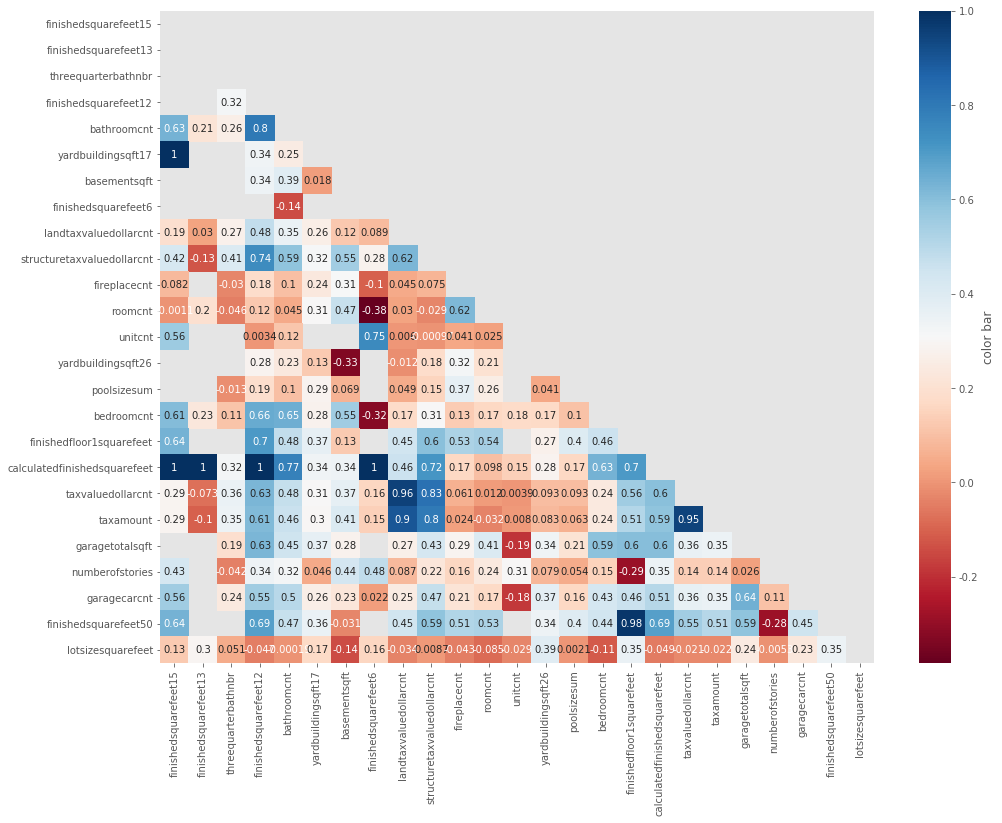

In [689]:
plt.figure(figsize = (16,12))
corr = df_prop_2016[num_list].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True #mask

sns.heatmap(corr, annot=True, cmap='RdBu', 
            mask = mask,
            annot_kws={"size":10}, cbar_kws={"label":"color bar"})

In [997]:
df_done_2016.corr()

,regionidcity_0,regionidcity_1,regionidcity_2,regionidcity_3,regionidcity_4,regionidcity_5,regionidcity_6,rawcensustractandblock_0,rawcensustractandblock_1,rawcensustractandblock_2,...,yearbuilt_3,yearbuilt_4,taxdelinquencyyear_0,taxdelinquencyyear_1,hashottuborspa_0,hashottuborspa_1,fireplaceflag_0,fireplaceflag_1,taxdelinquencyflag_0,taxdelinquencyflag_1
regionidcity_0,1.000,-0.123,6.757e-01,-0.425,-0.322,-0.162,-6.833e-01,-0.058,-0.043,0.003,...,-0.042,-0.038,-0.026,0.026,1.470e-02,-1.470e-02,-0.004,0.004,-0.026,0.026
regionidcity_1,-0.123,1.000,-3.524e-01,0.635,0.333,0.116,5.133e-02,-0.063,-0.058,0.015,...,-0.036,-0.045,-0.023,0.023,1.135e-02,-1.135e-02,0.019,-0.019,-0.023,0.023
regionidcity_2,0.676,-0.352,1.000e+00,-0.580,-0.518,-0.251,-6.535e-01,-0.108,0.047,-0.050,...,0.009,-0.018,-0.015,0.015,-4.361e-04,4.361e-04,0.003,-0.003,-0.015,0.015
regionidcity_3,-0.425,0.635,-5.800e-01,1.000,0.282,0.219,4.021e-01,-0.013,-0.017,-0.018,...,-0.011,-0.047,-0.008,0.008,1.741e-02,-1.741e-02,0.016,-0.016,-0.008,0.008
regionidcity_4,-0.322,0.333,-5.183e-01,0.282,1.000,0.186,2.323e-01,0.012,-0.006,0.051,...,-0.013,0.006,0.008,-0.008,1.222e-02,-1.222e-02,-0.011,0.011,0.008,-0.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hashottuborspa_1,-0.015,-0.011,4.361e-04,-0.017,-0.012,0.046,7.475e-03,0.021,0.011,-0.033,...,0.044,0.003,0.016,-0.016,-1.000e+00,1.000e+00,0.003,-0.003,0.016,-0.016
fireplaceflag_0,-0.004,0.019,2.798e-03,0.016,-0.011,-0.020,-7.882e-04,-0.001,-0.009,0.007,...,0.023,-0.046,-0.007,0.007,-2.543e-03,2.543e-03,1.000,-1.000,-0.007,0.007
fireplaceflag_1,0.004,-0.019,-2.798e-03,-0.016,0.011,0.020,7.882e-04,0.001,0.009,-0.007,...,-0.023,0.046,0.007,-0.007,2.543e-03,-2.543e-03,-1.000,1.000,0.007,-0.007
taxdelinquencyflag_0,-0.026,-0.023,-1.517e-02,-0.008,0.008,0.014,2.703e-02,0.011,0.014,-0.005,...,0.008,0.021,1.000,-1.000,-1.581e-02,1.581e-02,-0.007,0.007,1.000,-1.000


There are certain pairs of value that have extremely high correlation. Let's see what are their definitions.

'calculatedfinishedsquarefeet':  Calculated total finished living area of the home   
'finishedsquarefeet12': Finished living area  
'finishedsquarefeet13': Perimeter  living area  
'finishedsquarefeet15': Total area  
'finishedsquarefeet6': Base unfinished and finished area

In [690]:
df_prop_2016.calculatedfinishedsquarefeet.isna().sum()

661

After several observation, we can see some pattern between these variables.

The feature `calculatedfinishedsquarefeet` is in fact one of the value in the last four feature. Thus, we can drop the  last four features. 

In [691]:
df_prop_2016.drop(columns=['finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet6'], inplace=True)
df_prop_2017.drop(columns=['finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet6'], inplace=True)

Let's also see the relationship between `finishedsquarefeet15` and `yardbuildingsqft17`.

In [692]:
prop_2016[['finishedsquarefeet15','yardbuildingsqft17']].sample(10)

,finishedsquarefeet15,yardbuildingsqft17
1025974,15091.0,NaN
2194356,NaN,NaN
571640,NaN,NaN
1219807,NaN,NaN
318381,NaN,NaN
2473112,NaN,NaN
500809,NaN,NaN
2698624,NaN,NaN
2906417,1291.0,NaN
157559,NaN,NaN


After several observation, there are no relationship between the two variables. The cause of the correlation **1** is due to the fact that both features have immense amount of missing values.

Next, let's see the following four variable.

'landtaxvaluedollarcnt': The assessed value of the land area of the parcel  
'taxvaluedollarcnt': The total tax assessed value of the parcel  
'taxamount': The total property tax assessed for that assessment year  
'structuretaxvaluedollarcnt': The assessed value of the built structure on the parcel

In [693]:
prop_2016[['landtaxvaluedollarcnt','taxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt']].sample(5)

,landtaxvaluedollarcnt,taxvaluedollarcnt,taxamount,structuretaxvaluedollarcnt
1171876,20875.0,59146.0,1210.56,38271.0
766663,282589.0,457948.0,5636.01,175359.0
1193258,166712.0,227291.0,3574.76,60579.0
821233,36242.0,181217.0,4262.89,144975.0
1708417,254175.0,598927.0,5779.22,344752.0


One interesting fact among these four variables can be shown in the following formula:

$$taxvaluedollarcnt = landtaxvaluedollatcnt + structuretaxvaluedollarcnt$$

From the above heatmap, we can see that `landtaxvaluedollatcnt` and `structuretaxvaluedollarcnt` have moderate relationship.  But what about the relationship between `taxvaluedollarcnt` and `taxamount`?

In [694]:
_ = prop_2016[['taxvaluedollarcnt','taxamount']]
_['rate'] = (_['taxamount'] / _['taxvaluedollarcnt']).apply(lambda x: np.round(x, 3))

In [695]:
_.sample(10)

,taxvaluedollarcnt,taxamount,rate
2260971,550000.0,6627.32,0.012
1038270,696461.0,7359.30,0.011
2366971,367539.0,4516.54,0.012
2490474,752255.0,9365.13,0.012
234455,70843.0,1194.78,0.017
7960,743606.0,9095.60,0.012
1758363,74618.0,1076.75,0.014
845891,44372.0,826.08,0.019
1205109,525212.0,6449.76,0.012
382218,323270.0,3665.26,0.011


In [696]:
_[_.rate > 0.3].sample(10)

,taxvaluedollarcnt,taxamount,rate
2423897,16713.0,36574.54,2.188
549559,133842.0,55173.84,0.412
2281952,28713.0,10266.19,0.358
2854838,22.0,16.23,0.738
1279000,1488.0,15279.88,10.269
1784653,13000.0,7261.01,0.559
1873992,10588.0,7031.50,0.664
2260034,32007.0,18340.82,0.573
1531841,16765.0,16224.72,0.968
2083300,66657.0,20707.07,0.311


You can see there are much more ridiculous number of tax rate! We now have no idea what's happening. Thus, let's simply drop `taxvaluedollarcnt` and move on.

In [697]:
df_prop_2016.drop(columns=['taxvaluedollarcnt'], inplace=True)
df_prop_2017.drop(columns=['taxvaluedollarcnt'], inplace=True)

Lastly, let's see the relationship between `finishedsquarefeet50` and `finishedfloor1squarefeet`.

'finishedfloor1squarefeet':  Size of the finished living area on the first (entry) floor of the home

'finishedsquarefeet50': Size of the finished living area on the first (entry) floor of the home

Wait a minute.... This two variables have the same meaning???

In [698]:
prop_2016[['finishedsquarefeet50','finishedfloor1squarefeet']].sample(10)

,finishedsquarefeet50,finishedfloor1squarefeet
1197679,NaN,NaN
900432,NaN,NaN
1118042,NaN,NaN
2244929,NaN,NaN
120098,NaN,NaN
570058,NaN,NaN
1189335,NaN,NaN
2360136,NaN,NaN
1279847,1090.0,1090.0
689025,NaN,NaN


After careful observation we can see that these numbers are the same!

In [699]:
df_prop_2016.drop(columns=['finishedfloor1squarefeet'], inplace=True)
df_prop_2017.drop(columns=['finishedfloor1squarefeet'], inplace=True)

In [700]:
l = ['finishedfloor1squarefeet','taxvaluedollarcnt','finishedsquarefeet12',
     'finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet6']
for _ in l:
    num_list.remove(_)

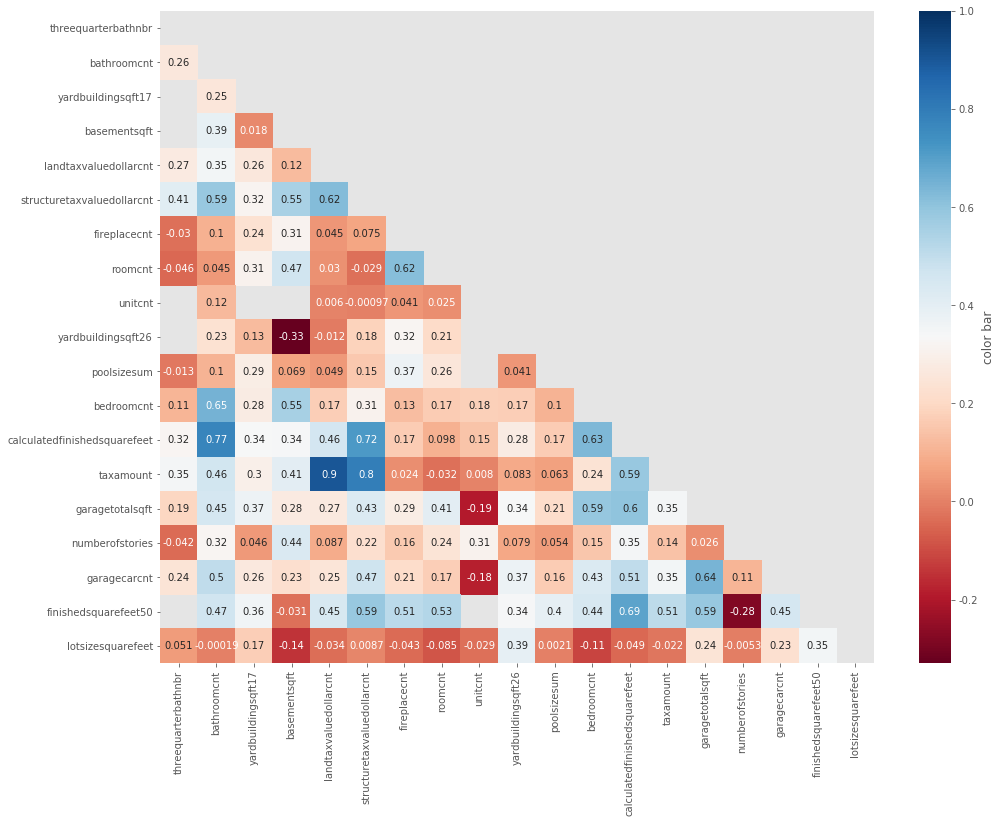

In [701]:
plt.figure(figsize = (16,12))
corr = df_prop_2016[num_list].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True #mask

sns.heatmap(corr, annot=True, cmap='RdBu', 
            mask = mask,
            annot_kws={"size":10}, cbar_kws={"label":"color bar"})

---
## MICE Imputation for Numerical Data

Reference: https://rpy2.github.io/doc/v3.2.x/html/pandas.html#r-and-pandas-data-frames

In [827]:
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

In [828]:
pandas2ri.activate()

In [829]:
mice = importr('mice')

### 2016

In [830]:
with localconverter(ro.default_converter + pandas2ri.converter):
    r_dataframe = ro.conversion.py2rpy(df_prop_2016[num_list])

In [831]:
imputed_r_dataframe = mice.mice(r_dataframe, m = 10, maxit = 10)


 iter imp variable
  1   1  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  1   2  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  1   3  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  1   4  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  calculatedfinishedsquarefeet  basementsqft 

  6   7  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  6   8  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  6   9  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  6   10  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  calculatedfinishedsquarefeet  basementsqft  threequarterbathnb

In [832]:
df_mice_2016 = mice.complete_mids(imputed_r_dataframe)
df_mice_2016.head()

,structuretaxvaluedollarcnt,yardbuildingsqft26,finishedsquarefeet50,bathroomcnt,calculatedfinishedsquarefeet,basementsqft,threequarterbathnbr,taxamount,poolsizesum,bedroomcnt,landtaxvaluedollarcnt,unitcnt,garagecarcnt,numberofstories,fireplacecnt,roomcnt,garagetotalsqft,yardbuildingsqft17,lotsizesquarefeet
1,0.012,0.215,0.142,0.20,0.074,0.859,0.0,0.021,0.0,0.3,0.010,0.0,0.083,0.333,0.0,0.000,0.065,0.081,1.056e-03
2,0.035,0.017,0.190,0.35,0.099,1.000,0.0,0.031,0.0,0.4,0.010,0.0,0.083,0.000,0.0,0.000,0.064,0.082,4.986e-04
3,0.006,0.079,0.203,0.30,0.097,0.981,0.0,0.036,0.0,0.2,0.002,0.0,0.042,0.333,0.0,0.000,0.027,0.160,1.615e-03
4,0.017,0.017,0.100,0.20,0.037,0.285,0.0,0.009,0.0,0.2,0.003,0.0,0.083,0.000,0.0,0.000,0.061,0.054,1.014e-02
5,0.017,0.283,0.152,0.25,0.100,0.981,0.0,0.017,0.0,0.4,0.011,0.0,0.083,0.333,0.0,0.444,0.081,0.072,8.368e-04


In [833]:
df_mice_2016.to_csv('df_mice_2016.csv')

### 2017

In [834]:
with localconverter(ro.default_converter + pandas2ri.converter):
    r_dataframe = ro.conversion.py2rpy(df_prop_2017[num_list])

In [835]:
imputed_r_dataframe = mice.mice(r_dataframe, m = 10, maxit = 10)


 iter imp variable
  1   1  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  bathroomcnt  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  bedroomcnt  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  roomcnt  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  1   2  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  bathroomcnt  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  bedroomcnt  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  roomcnt  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  1   3  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  bathroomcnt  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  bedroomcnt  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  roomcnt  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  1   4  structureta

  6   1  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  bathroomcnt  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  bedroomcnt  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  roomcnt  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  6   2  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  bathroomcnt  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  bedroomcnt  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  roomcnt  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  6   3  structuretaxvaluedollarcnt  yardbuildingsqft26  finishedsquarefeet50  bathroomcnt  calculatedfinishedsquarefeet  basementsqft  threequarterbathnbr  taxamount  poolsizesum  bedroomcnt  landtaxvaluedollarcnt  unitcnt  garagecarcnt  numberofstories  roomcnt  garagetotalsqft  yardbuildingsqft17  lotsizesquarefeet
  6   4  structuretaxvaluedollarcnt  yar

In [836]:
df_mice_2017 = mice.complete_mids(imputed_r_dataframe)
df_mice_2017.head()

,structuretaxvaluedollarcnt,yardbuildingsqft26,finishedsquarefeet50,bathroomcnt,calculatedfinishedsquarefeet,basementsqft,threequarterbathnbr,taxamount,poolsizesum,bedroomcnt,landtaxvaluedollarcnt,unitcnt,garagecarcnt,numberofstories,fireplacecnt,roomcnt,garagetotalsqft,yardbuildingsqft17,lotsizesquarefeet
1,0.043,0.118,0.206,0.35,0.084,0.391,0.0,0.019,0.0,0.4,1.098e-02,0.0,0.143,0.0,0.0,0.000,0.149,0.096,6.126e-04
2,0.008,0.032,0.114,0.10,0.038,0.171,0.0,0.010,0.0,0.2,7.678e-03,0.0,0.071,0.0,0.2,0.333,0.000,0.064,1.780e-03
3,0.007,0.005,0.086,0.20,0.031,0.335,0.0,0.011,0.0,0.3,9.792e-03,0.0,0.143,0.0,0.0,0.400,0.103,0.149,1.176e-03
4,0.010,0.118,0.197,0.30,0.063,0.135,0.0,0.003,0.0,0.4,7.367e-04,0.0,0.143,0.0,0.0,0.000,0.130,0.047,1.837e-03
5,0.006,0.070,0.110,0.30,0.033,0.181,0.0,0.003,0.0,0.3,9.308e-04,0.0,0.143,0.0,0.0,0.000,0.000,0.037,3.993e-02


In [837]:
df_mice_2017.to_csv('df_mice_2017.csv')

---
## Embedding

### Prepare Embedding Dataset

In [702]:
embed_list

['regionidcity',
 'regionidzip',
 'latitude',
 'longitude',
 'rawcensustractandblock',
 'propertycountylandusecode',
 'propertyzoningdesc']

In [703]:
cat_list

['airconditioningtypeid',
 'buildingqualitytypeid',
 'fips',
 'regionidcounty',
 'heatingorsystemtypeid',
 'propertylandusetypeid',
 'storytypeid',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'yearbuilt',
 'taxdelinquencyyear',
 'hashottuborspa',
 'fireplaceflag',
 'taxdelinquencyflag']

In [704]:
resumetable(df_prop_2016[['logerror'] + list(embed_list) + list(cat_list)])

Dataset Shape: (90275, 24)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,logerror,float16,0,0.000,1890,0.0276,-0.168,-0.004,8.31
1,regionidcity,float32,1803,1.997,177,1.24e+04,3.24e+04,4.7e+04,5.90
2,regionidzip,float32,35,0.039,388,9.64e+04,9.7e+04,9.63e+04,8.29
3,latitude,float32,0,0.000,63620,3.43e+07,3.37e+07,3.41e+07,15.64
4,longitude,float32,0,0.000,57817,-1.18e+08,-1.18e+08,-1.18e+08,15.29
5,rawcensustractandblock,float32,0,0.000,470,6.04e+07,6.06e+07,6.04e+07,7.98
6,propertycountylandusecode,object,1,0.001,77,0100,1,0100,3.20
7,propertyzoningdesc,object,31962,35.405,1996,LARS,NaN,PSR6,7.89
8,airconditioningtypeid,object,0,0.000,6,Central,No Airconditioning,Central,1.02
9,buildingqualitytypeid,object,0,0.000,5,upper,MissingValue,upper,1.82


### Define new embed_list

In [705]:
embed_list = ['regionidcity', 'latitude', 'longitude', 'rawcensustractandblock', 
            'propertycountylandusecode','airconditioningtypeid', 'buildingqualitytypeid', 'fips', 
              'heatingorsystemtypeid', 'propertylandusetypeid']

cat_list are those only present Binary values or columns not suitable for establishing relationships.

In [706]:
cat_list = ['storytypeid','poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7','yearbuilt',
           'taxdelinquencyyear','hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']

In [1012]:
num_list

{'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet50',
 'fireplacecnt',
 'garagecarcnt',
 'garagetotalsqft',
 'landtaxvaluedollarcnt',
 'lotsizesquarefeet',
 'numberofstories',
 'poolsizesum',
 'roomcnt',
 'structuretaxvaluedollarcnt',
 'taxamount',
 'threequarterbathnbr',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

In [1013]:
len(cat_list) + len(num_list) + len(embed_list)

39

We are going to drop some of the features that might have high relationships.

1. regionidcounty, regionidzip, regionidcounty, and latitude & longitude all gives geographical information.

2. propertycountylandusecode and propertyzoningdesc both talk about land uses.

In [707]:
drop_list.extend(['regionidzip','propertyzoningdesc','regionidcounty'])

In [1021]:
drop_list

['architecturalstyletypeid',
 'buildingclasstypeid',
 'calculatedbathnbr',
 'decktypeid',
 'fullbathcnt',
 'censustractandblock',
 'typeconstructiontypeid',
 'assessmentyear',
 'regionidneighborhood',
 'regionidzip',
 'propertyzoningdesc',
 'regionidcounty']

In [721]:
embed_2016 = df_prop_2016[['logerror'] + list(embed_list)]
embed_2017 = df_prop_2017[['logerror'] + list(embed_list)]
embed_2016

,logerror,regionidcity,latitude,longitude,rawcensustractandblock,propertycountylandusecode,airconditioningtypeid,buildingqualitytypeid,fips,heatingorsystemtypeid,propertylandusetypeid
0,0.028,12447.0,3.428e+07,-1.185e+08,6.037e+07,0100,Central,upper,Code1,Central,Single Family Residential
1,-0.168,32380.0,3.367e+07,-1.177e+08,6.059e+07,1,No Airconditioning,MissingValue,Code2,MissingValue,Single Family Residential
2,-0.004,47019.0,3.414e+07,-1.182e+08,6.037e+07,0100,Central,upper,Code1,Central,Single Family Residential
3,0.022,12447.0,3.376e+07,-1.183e+08,6.037e+07,010C,Central,upper,Code1,Central,Condominium
4,-0.005,17686.0,3.349e+07,-1.177e+08,6.059e+07,122,No Airconditioning,MissingValue,Code2,MissingValue,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...
90270,-0.036,12447.0,3.420e+07,-1.186e+08,6.037e+07,010C,Central,upper,Code1,Central,Condominium
90271,0.007,45457.0,3.420e+07,-1.182e+08,6.037e+07,0100,No Airconditioning,upper,Code1,Central,Single Family Residential
90272,-0.268,51861.0,3.408e+07,-1.180e+08,6.037e+07,0200,No Airconditioning,lower,Code1,MissingValue,Duplex
90273,0.060,45888.0,3.396e+07,-1.184e+08,6.038e+07,010C,No Airconditioning,upper,Code1,Central,Condominium


In [722]:
resumetable(embed_2016)

Dataset Shape: (90275, 11)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,logerror,float16,0,0.000,1890,0.0276,-0.168,-0.004,8.31
1,regionidcity,float32,1803,1.997,177,1.24e+04,3.24e+04,4.7e+04,5.90
2,latitude,float32,0,0.000,63620,3.43e+07,3.37e+07,3.41e+07,15.64
3,longitude,float32,0,0.000,57817,-1.18e+08,-1.18e+08,-1.18e+08,15.29
4,rawcensustractandblock,float32,0,0.000,470,6.04e+07,6.06e+07,6.04e+07,7.98
5,propertycountylandusecode,object,1,0.001,77,0100,1,0100,3.20
6,airconditioningtypeid,object,0,0.000,6,Central,No Airconditioning,Central,1.02
7,buildingqualitytypeid,object,0,0.000,5,upper,MissingValue,upper,1.82
8,fips,object,0,0.000,3,Code1,Code2,Code1,1.21
9,heatingorsystemtypeid,object,0,0.000,9,Central,MissingValue,Central,1.66


In [723]:
resumetable(embed_2017)

Dataset Shape: (77613, 11)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,logerror,float16,0,0.000,17900,0.0256,0.0556,0.00538,13.68
1,regionidcity,float32,1506,1.940,175,5.36e+04,1.31e+04,2.14e+04,5.88
2,latitude,float32,34,0.044,56706,3.36e+07,3.44e+07,3.39e+07,15.51
3,longitude,float32,34,0.044,51573,-1.18e+08,-1.19e+08,-1.18e+08,15.16
4,rawcensustractandblock,float32,34,0.044,469,6.06e+07,6.11e+07,6.06e+07,8.00
5,propertycountylandusecode,object,34,0.044,75,122,1110,122,3.19
6,airconditioningtypeid,object,0,0.000,5,No Airconditioning,No Airconditioning,No Airconditioning,1.02
7,buildingqualitytypeid,object,0,0.000,5,MissingValue,MissingValue,MissingValue,1.72
8,fips,object,34,0.044,3,Code2,Code3,Code2,1.20
9,heatingorsystemtypeid,object,0,0.000,9,MissingValue,MissingValue,MissingValue,1.67


In [724]:
_ = ['regionidcity','fips','propertycountylandusecode','rawcensustractandblock']
for col in _:
    embed_2016[col] = embed_2016[col].fillna('NAN')
    embed_2017[col] = embed_2017[col].fillna('NAN')

# Change Data Type
for col in embed_2016.columns:
    embed_2016[col] = embed_2016[col].astype(str)
    embed_2017[col] = embed_2017[col].astype(str)

In [727]:
embed_all = pd.concat([embed_2016,embed_2017]).reset_index(drop=True)

In [728]:
resumetable(embed_all)

Dataset Shape: (167888, 11)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,logerror,object,0,0.0,18705,0.0276,-0.1685,-0.004,11.69
1,regionidcity,object,0,0.0,179,12447.0,32380.0,47019.0,5.92
2,latitude,object,0,0.0,99811,34280990.0,33668120.0,34136310.0,16.16
3,longitude,object,0,0.0,87712,-118488536.0,-117677550.0,-118175030.0,15.73
4,rawcensustractandblock,object,0,0.0,563,60371068.0,60590524.0,60374640.0,8.16
5,propertycountylandusecode,object,0,0.0,91,0100,1,0100,3.20
6,airconditioningtypeid,object,0,0.0,6,Central,No Airconditioning,Central,1.02
7,buildingqualitytypeid,object,0,0.0,5,upper,MissingValue,upper,1.78
8,fips,object,0,0.0,4,Code1,Code2,Code1,1.21
9,heatingorsystemtypeid,object,0,0.0,9,Central,MissingValue,Central,1.66


### Latitude vs Longitude

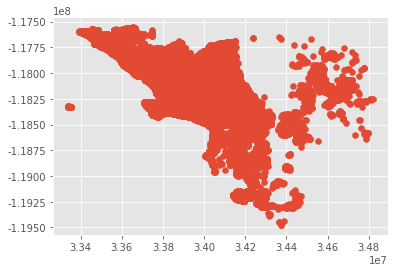

In [729]:
plt.scatter(data=df_prop_2017, x = 'latitude', y = 'longitude')

It's almost impossible and computationally expensive to encode all different longitude and latitude. Thus, let's use clustering algorithm to allocate them into clusters.

In [730]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [733]:
latlon = embed_all[['latitude','longitude']]
latlon.sample(10)

,latitude,longitude
150709,34444964.0,-118473030.0
78183,34189784.0,-118297810.0
136491,33603000.0,-117734000.0
71395,34136300.0,-118707000.0
80550,34269110.0,-118557390.0
70113,33788930.0,-118106260.0
28228,33763588.0,-118305250.0
139574,34563480.0,-118040024.0
79476,33658760.0,-117830560.0
35607,34444116.0,-118474480.0


In [760]:
latlon[col].apply(laddmbda x: float(x))/10e6

0        -11.849
1        -11.768
2        -11.818
3        -11.831
4        -11.770
           ...  
167883   -11.850
167884   -11.828
167885   -11.871
167886   -11.804
167887   -11.800
Name: longitude, Length: 167888, dtype: float64

In [761]:
for col in latlon.columns:
    latlon[col] = latlon[col].apply(lambda x: float(x))/10e6

In [762]:
latlon = latlon.fillna(latlon.mean())

In [764]:
# Silhouette + Elbow Method
davies = [] 
mapping_dav = {} 

K = range(2,31)

for k in K: 
    
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k)
    pred = kmeanModel.fit_predict(latlon)     
    
    dav = davies_bouldin_score(latlon, pred)
    davies.append(dav)
    mapping_dav[k] = dav

    print(f"Iteration {k} finished.")

Iteration 2 finished.
Iteration 3 finished.
Iteration 4 finished.
Iteration 5 finished.
Iteration 6 finished.
Iteration 7 finished.
Iteration 8 finished.
Iteration 9 finished.
Iteration 10 finished.
Iteration 11 finished.
Iteration 12 finished.
Iteration 13 finished.
Iteration 14 finished.
Iteration 15 finished.
Iteration 16 finished.
Iteration 17 finished.
Iteration 18 finished.
Iteration 19 finished.
Iteration 20 finished.
Iteration 21 finished.
Iteration 22 finished.
Iteration 23 finished.
Iteration 24 finished.
Iteration 25 finished.
Iteration 26 finished.
Iteration 27 finished.
Iteration 28 finished.
Iteration 29 finished.
Iteration 30 finished.


In [765]:
mapping_dav

{2: 0.7971397486064913,
 3: 0.8341241872087309,
 4: 0.8805775296887076,
 5: 0.7747805140022357,
 6: 0.7480100327686864,
 7: 0.7502594124805626,
 8: 0.7440420600021505,
 9: 0.7339217447104887,
 10: 0.7123041318450443,
 11: 0.7120517495462256,
 12: 0.6989328339408347,
 13: 0.7451254001477519,
 14: 0.7445118824805442,
 15: 0.7441653930386851,
 16: 0.7371007594924787,
 17: 0.7336627186816538,
 18: 0.7219688835051716,
 19: 0.7498272507488347,
 20: 0.7577064952137154,
 21: 0.7874310474618286,
 22: 0.7837980394646998,
 23: 0.8029370526977838,
 24: 0.8166964695076654,
 25: 0.8026084410034856,
 26: 0.7984467580403287,
 27: 0.8127337034262612,
 28: 0.8162191768302446,
 29: 0.7949625156035417,
 30: 0.8289934759124677}

k = 12 is the best!

In [766]:
kmeanModel = KMeans(n_clusters=12)
pred = kmeanModel.fit_predict(latlon)
pred

array([ 7,  9,  3, ..., 10,  3,  6], dtype=int32)

In [767]:
len(df_prop_2016), len(df_prop_2017)

(90275, 77613)

In [768]:
embed_2016['geo_cluster'] = pred[:len(df_prop_2016)]
embed_2017['geo_cluster'] = pred[len(df_prop_2016):]

embed_2016.drop(columns=['latitude','longitude'], inplace=True)
embed_2017.drop(columns=['latitude','longitude'], inplace=True)

embed_all = pd.concat([embed_2016,embed_2017]).reset_index(drop=True)

In [769]:
embed_all

,logerror,regionidcity,rawcensustractandblock,propertycountylandusecode,airconditioningtypeid,buildingqualitytypeid,fips,heatingorsystemtypeid,propertylandusetypeid,geo_cluster
0,0.0276,12447.0,60371068.0,0100,Central,upper,Code1,Central,Single Family Residential,7
1,-0.1685,32380.0,60590524.0,1,No Airconditioning,MissingValue,Code2,MissingValue,Single Family Residential,9
2,-0.004,47019.0,60374640.0,0100,Central,upper,Code1,Central,Single Family Residential,3
3,0.0218,12447.0,60372964.0,010C,Central,upper,Code1,Central,Condominium,0
4,-0.005,17686.0,60590424.0,122,No Airconditioning,MissingValue,Code2,MissingValue,Single Family Residential,9
...,...,...,...,...,...,...,...,...,...,...
167883,-0.002245,12447.0,60371320.0,010C,Central,lower,Code1,Central,Condominium,7
167884,0.02061,12447.0,60371016.0,0100,No Airconditioning,upper,Code1,Central,Single Family Residential,3
167885,0.01321,27110.0,61110084.0,1111,No Airconditioning,MissingValue,Code3,MissingValue,Single Family Residential,10
167886,0.03714,36502.0,60374340.0,0100,Central,upper,Code1,Central,Single Family Residential,3


### Embedding

In [772]:
resumetable(embed_all)

Dataset Shape: (167888, 10)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,logerror,object,0,0.0,18705,0.0276,-0.1685,-0.004,11.69
1,regionidcity,object,0,0.0,179,12447.0,32380.0,47019.0,5.92
2,rawcensustractandblock,object,0,0.0,563,60371068.0,60590524.0,60374640.0,8.16
3,propertycountylandusecode,object,0,0.0,91,0100,1,0100,3.20
4,airconditioningtypeid,object,0,0.0,6,Central,No Airconditioning,Central,1.02
5,buildingqualitytypeid,object,0,0.0,5,upper,MissingValue,upper,1.78
6,fips,object,0,0.0,4,Code1,Code2,Code1,1.21
7,heatingorsystemtypeid,object,0,0.0,9,Central,MissingValue,Central,1.66
8,propertylandusetypeid,object,0,0.0,14,Single Family Residential,Single Family Residential,Single Family Residential,1.34
9,geo_cluster,int32,0,0.0,12,7,9,3,3.47


In [773]:
dim = {'regionidcity': 179, 'rawcensustractandblock': 563, 'propertycountylandusecode': 91, 
       'airconditioningtypeid': 6, 'buildingqualitytypeid': 5, 'fips': 4,
       'heatingorsystemtypeid': 9, 'propertylandusetypeid': 14,'geo_cluster': 12}

In [776]:
X = embed_all.drop(columns=['logerror'])
y = embed_all[['logerror']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [775]:
dim

{'regionidcity': 179,
 'rawcensustractandblock': 563,
 'propertycountylandusecode': 91,
 'airconditioningtypeid': 6,
 'buildingqualitytypeid': 5,
 'fips': 4,
 'heatingorsystemtypeid': 9,
 'propertylandusetypeid': 14,
 'geo_cluster': 12}

In [780]:
def build_embedding_network(dim):
    # my rule: np.floor(log2(x))
    dim = list(dim.items())
    inputs = []
    embeddings = []
    
    input_regionidcity = Input(shape=(1,))
    embedding = Embedding(179, 7, input_length=1)(input_regionidcity)
    embedding = Reshape(target_shape=(7,))(embedding)
    inputs.append(input_regionidcity)
    embeddings.append(embedding)

    input_rawcensustractandblock = Input(shape=(1,))
    embedding = Embedding(563, 9, input_length=1)(input_rawcensustractandblock)
    embedding = Reshape(target_shape=(9,))(embedding)
    inputs.append(input_rawcensustractandblock)
    embeddings.append(embedding)
    
    input_propertycountylandusecode = Input(shape=(1,))
    embedding = Embedding(91, 6, input_length=1)(input_propertycountylandusecode)
    embedding = Reshape(target_shape=(6,))(embedding)
    inputs.append(input_propertycountylandusecode)
    embeddings.append(embedding)
    
    input_airconditioningtypeid = Input(shape=(1,))
    embedding = Embedding(6, 2, input_length=1)(input_airconditioningtypeid)
    embedding = Reshape(target_shape=(2,))(embedding)
    inputs.append(input_airconditioningtypeid)
    embeddings.append(embedding)
    
    input_buildingqualitytypeid = Input(shape=(1,))
    embedding = Embedding(5, 2, input_length=1)(input_buildingqualitytypeid)
    embedding = Reshape(target_shape=(2,))(embedding)
    inputs.append(input_buildingqualitytypeid)
    embeddings.append(embedding)

    input_fips = Input(shape=(1,))
    embedding = Embedding(4, 2, input_length=1)(input_fips)
    embedding = Reshape(target_shape=(2,))(embedding)
    inputs.append(input_fips)
    embeddings.append(embedding)

    input_heatingorsystemtypeid = Input(shape=(1,))
    embedding = Embedding(9, 3, input_length=1)(input_heatingorsystemtypeid)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_heatingorsystemtypeid)
    embeddings.append(embedding)
    
    input_propertylandusetypeid = Input(shape=(1,))
    embedding = Embedding(14, 3, input_length=1)(input_propertylandusetypeid)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_propertylandusetypeid)
    embeddings.append(embedding)
    
    input_geo_cluster = Input(shape=(1,))
    embedding = Embedding(12, 3, input_length=1)(input_geo_cluster)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_geo_cluster)
    embeddings.append(embedding)

    x = Concatenate()(embeddings)
    x = Dense(80, activation='relu')(x)
    x = Dropout(.4)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(.25)(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(.2)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, output)

    model.compile(loss='mse', optimizer='adam', metrics = ['mse'])
    
    return(model)

In [781]:
# dim
dim = {'regionidcity': 179, 'rawcensustractandblock': 563, 'propertycountylandusecode': 91, 
       'airconditioningtypeid': 6, 'buildingqualitytypeid': 5, 'fips': 4,
       'heatingorsystemtypeid': 9, 'propertylandusetypeid': 14,'geo_cluster': 12}

# network training
iters = 8
n_epochs = 12

# cv_ginis = []
# full_val_preds = np.zeros(np.shape(X_train)[0])
# y_preds = np.zeros((np.shape(X_test)[0],K))

result = {'input_regionidcity': [],
         'input_rawcensustractandblock': [],
         'input_propertycountylandusecode': [],
         'input_airconditioningtypeid': [],
         'input_buildingqualitytypeid': [],
         'input_fips': [],
         'input_heatingorsystemtypeid': [],
         'input_propertylandusetypeid': [],
         'input_geo_cluster': []}

ind_to_result = {9:  'input_regionidcity',
                 10: 'input_rawcensustractandblock',
                 11: 'input_propertycountylandusecode',
                 12: 'input_airconditioningtypeid',
                 13: 'input_buildingqualitytypeid',
                 14: 'input_fips',
                 15: 'input_heatingorsystemtypeid',
                 16: 'input_propertylandusetypeid',
                 17: 'input_geo_cluster'}

columns = list(dim.keys())

X = []
y = embed_all.logerror.values.astype(float)

for col in columns:
    embed_all[col] = LabelEncoder().fit_transform(embed_all[col].astype(str))
    raw_vals = np.unique(embed_all[col])
    val_map = {}
    for i in range(len(raw_vals)):
        val_map[raw_vals[i]] = i       
    X.append(embed_all[col].map(val_map).values)

for i in range(iters):
    print(f"Iteration {i+1} Starts.")
    NN = build_embedding_network(dim)
    NN.fit(X, y, epochs=n_epochs, batch_size=256, verbose=1)
    
    for ind in list(ind_to_result.keys()):
        result[ind_to_result[ind]].append(NN.layers[ind].get_weights()[0])

Iteration 1 Starts.
Epoch 1/12
167888/167888 [==============================] - 14s 81us/step - loss: 0.1049 - mse: 0.0363
Epoch 2/12
167888/167888 [==============================] - 12s 70us/step - loss: 0.0698 - mse: 0.0276
Epoch 3/12
167888/167888 [==============================] - 12s 69us/step - loss: 0.0613 - mse: 0.0276
Epoch 4/12
167888/167888 [==============================] - 12s 71us/step - loss: 0.0552 - mse: 0.0275
Epoch 5/12
167888/167888 [==============================] - 12s 70us/step - loss: 0.0518 - mse: 0.0275
Epoch 6/12
167888/167888 [==============================] - 11s 68us/step - loss: 0.0480 - mse: 0.0274
Epoch 7/12
167888/167888 [==============================] - 11s 63us/step - loss: 0.0439 - mse: 0.0274
Epoch 8/12
167888/167888 [==============================] - 12s 69us/step - loss: 0.0419 - mse: 0.0274
Epoch 9/12
167888/167888 [==============================] - 12s 69us/step - loss: 0.0402 - mse: 0.0273
Epoch 10/12
167888/167888 [==========================

In [794]:
# calculate the entity embedding vectors by averaging over the eight trials
keys = list(result.keys())

results = {'input_regionidcity': [],
         'input_rawcensustractandblock': [],
         'input_propertycountylandusecode': [],
         'input_airconditioningtypeid': [],
         'input_buildingqualitytypeid': [],
         'input_fips': [],
         'input_heatingorsystemtypeid': [],
         'input_propertylandusetypeid': [],
         'input_geo_cluster': []}

for key in keys:
    results[key] = np.mean(result[key],axis=0)

In [803]:
results

{'input_regionidcity': array([[-0.0146,  0.0358, -0.035 , ..., -0.0069, -0.013 ,  0.02  ],
        [ 0.0036, -0.0284,  0.0463, ..., -0.0362, -0.0042, -0.0139],
        [-0.0675,  0.0328, -0.1108, ...,  0.0151, -0.0113,  0.0588],
        ...,
        [-0.0315,  0.076 , -0.0732, ...,  0.0418, -0.0413,  0.0342],
        [-0.0591,  0.06  , -0.0706, ...,  0.0317, -0.0288,  0.0149],
        [ 0.0242, -0.0244,  0.0062, ...,  0.0088, -0.0184,  0.0025]],
       dtype=float32),
 'input_rawcensustractandblock': array([[ 0.004 ,  0.0189,  0.0276, ...,  0.0197, -0.0404,  0.0365],
        [ 0.0155, -0.024 ,  0.0883, ...,  0.0133, -0.0216,  0.0339],
        [-0.0348, -0.0025, -0.064 , ...,  0.0055,  0.0235, -0.0065],
        ...,
        [-0.0141, -0.0492, -0.0186, ...,  0.0217,  0.0052,  0.0391],
        [ 0.0076,  0.0171, -0.0548, ..., -0.0021,  0.0607, -0.0476],
        [ 0.0068, -0.0106,  0.0189, ...,  0.0022, -0.0046,  0.0056]],
       dtype=float32),
 'input_propertycountylandusecode': array([[

In [804]:
embed_all

,logerror,regionidcity,rawcensustractandblock,propertycountylandusecode,airconditioningtypeid,buildingqualitytypeid,fips,heatingorsystemtypeid,propertylandusetypeid,geo_cluster
0,0.0276,95,24,12,0,4,0,1,3,11
1,-0.1685,164,449,51,2,0,1,4,3,3
2,-0.004,48,263,12,0,4,0,1,3,7
3,0.0218,95,181,2,0,4,0,1,6,0
4,-0.005,118,448,69,2,0,1,4,3,3
...,...,...,...,...,...,...,...,...,...,...
167883,-0.002245,95,517,2,0,2,0,1,6,11
167884,0.02061,95,1,12,2,4,0,1,3,7
167885,0.01321,152,510,59,2,0,2,4,3,4
167886,0.03714,9,249,12,0,4,0,1,3,7


In [823]:
# embed_all['input_regionidcity']

In [827]:
tuple(results.keys())[0].split('_')[1:]

['regionidcity']

In [849]:
embed_all['regionidcity']

0          95
1         164
2          48
3          95
4         118
         ... 
167883     95
167884     95
167885    152
167886      9
167887    107
Name: regionidcity, Length: 167888, dtype: int64

In [845]:
pd.DataFrame(results['input_regionidcity']).reset_index()['index'][95]

95

In [836]:
results[tuple(results.keys())[0]].shape

(179, 7)

In [862]:
pd.DataFrame(results[tuple(results.keys())[-1]]).rename_axis('key').reset_index()

,key,0,1,2
0,0,1.249e-02,-0.018,0.009
1,1,-1.723e-02,0.026,-0.012
2,2,-2.378e-02,0.036,-0.067
3,3,-4.015e-03,0.032,-0.009
4,4,-1.221e-02,0.018,-0.017
5,5,1.505e-02,-0.073,0.067
6,6,-6.211e-03,0.028,-0.052
7,7,-2.505e-03,0.003,0.028
8,8,1.676e-02,-0.014,0.013
9,9,4.746e-03,0.048,-0.065


In [859]:
tuple(results.keys())[0]

'input_regionidcity'

In [873]:
def embedding_to_df(embed_all, results):
    cols = tuple(results.keys())
    vals = tuple(results.values())
    inds = embed_all.columns[1:]
    
    for col,ind in zip(cols,inds):
        colname = ['key']
        shape = results[col].shape
        df = pd.DataFrame(results[col]).rename_axis('key').reset_index()
        # Create col names
        for _ in range(shape[-1]):
            colname.append(f"{ind}_{_}")
        df.columns = colname
        embed_all = pd.merge(embed_all, df, how='left', left_on=ind, right_on='key').drop(columns=['key'])
    return(embed_all)

In [913]:
embedding_df = embedding_to_df(embed_all, results)
embedding_df = embedding_df[['logerror'] + list(embedding_df.columns[10:])]

In [914]:
len(df_2016), len(df_2017)

(90275, 77613)

In [958]:
df_embed_2016 = embedding_df.iloc[:len(df_2016)].reset_index(drop=True)
df_embed_2017 = embedding_df.iloc[len(df_2016):].reset_index(drop=True)

In [931]:
df_embed_2016

,logerror,regionidcity_0,regionidcity_1,regionidcity_2,regionidcity_3,regionidcity_4,regionidcity_5,regionidcity_6,rawcensustractandblock_0,rawcensustractandblock_1,...,fips_1,heatingorsystemtypeid_0,heatingorsystemtypeid_1,heatingorsystemtypeid_2,propertylandusetypeid_0,propertylandusetypeid_1,propertylandusetypeid_2,geo_cluster_0,geo_cluster_1,geo_cluster_2
0,0.0276,0.005,-0.025,0.008,-2.753e-02,0.005,0.005,3.284e-04,0.023,-0.006,...,0.003,-0.012,0.078,-0.022,8.978e-04,-0.009,-0.027,0.013,0.077,-0.087
1,-0.1685,0.035,0.017,0.011,1.234e-02,-0.012,0.002,-4.199e-02,-0.020,-0.007,...,-0.028,-0.017,0.034,-0.028,8.978e-04,-0.009,-0.027,-0.004,0.032,-0.009
2,-0.004,0.059,0.009,0.037,-8.333e-04,0.002,0.017,-2.861e-02,0.010,0.063,...,0.003,-0.012,0.078,-0.022,8.978e-04,-0.009,-0.027,-0.003,0.003,0.028
3,0.0218,0.005,-0.025,0.008,-2.753e-02,0.005,0.005,3.284e-04,-0.032,-0.105,...,0.003,-0.012,0.078,-0.022,1.023e-02,0.048,0.034,0.012,-0.018,0.009
4,-0.005,0.015,-0.004,0.025,4.947e-03,-0.021,0.029,-1.248e-02,0.008,-0.028,...,-0.028,-0.017,0.034,-0.028,8.978e-04,-0.009,-0.027,-0.004,0.032,-0.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,-0.0356,0.005,-0.025,0.008,-2.753e-02,0.005,0.005,3.284e-04,0.009,-0.064,...,0.003,-0.012,0.078,-0.022,1.023e-02,0.048,0.034,0.013,0.077,-0.087
90271,0.007,0.032,-0.002,-0.012,1.422e-02,-0.004,-0.004,3.208e-03,0.021,-0.062,...,0.003,-0.012,0.078,-0.022,8.978e-04,-0.009,-0.027,-0.003,0.003,0.028
90272,-0.2678,0.003,0.028,-0.020,8.411e-03,0.011,0.005,9.609e-03,-0.008,-0.006,...,0.003,-0.017,0.034,-0.028,-1.477e-02,-0.009,0.038,-0.003,0.003,0.028
90273,0.0602,0.011,0.044,0.010,-1.547e-02,-0.014,0.006,-9.030e-03,0.009,-0.019,...,0.003,-0.012,0.078,-0.022,1.023e-02,0.048,0.034,0.015,-0.073,0.067


In [932]:
df_embed_2017

,logerror,regionidcity_0,regionidcity_1,regionidcity_2,regionidcity_3,regionidcity_4,regionidcity_5,regionidcity_6,rawcensustractandblock_0,rawcensustractandblock_1,...,fips_1,heatingorsystemtypeid_0,heatingorsystemtypeid_1,heatingorsystemtypeid_2,propertylandusetypeid_0,propertylandusetypeid_1,propertylandusetypeid_2,geo_cluster_0,geo_cluster_1,geo_cluster_2
90275,0.02559,-0.020,-0.006,-0.010,-0.005,-1.563e-04,-0.015,3.030e-02,2.579e-02,4.006e-03,...,-0.028,-0.017,0.034,-0.028,8.978e-04,-0.009,-0.027,-6.211e-03,0.028,-0.052
90276,0.05563,-0.001,-0.027,-0.012,-0.016,5.772e-03,0.015,1.620e-02,1.085e-02,-4.349e-02,...,-0.013,-0.017,0.034,-0.028,8.978e-04,-0.009,-0.027,-1.723e-02,0.026,-0.012
90277,0.005383,0.032,-0.021,0.038,-0.012,2.184e-02,-0.012,-1.542e-02,-1.766e-03,-5.097e-05,...,-0.028,-0.017,0.034,-0.028,8.978e-04,-0.009,-0.027,-6.211e-03,0.028,-0.052
90278,-0.1034,0.030,0.015,0.014,-0.010,2.904e-03,-0.023,-1.014e-02,-1.683e-02,4.116e-02,...,0.003,-0.012,0.078,-0.022,8.978e-04,-0.009,-0.027,-2.505e-03,0.003,0.028
90279,0.00694,0.005,-0.025,0.008,-0.028,4.986e-03,0.005,3.284e-04,2.323e-02,-2.206e-02,...,0.003,-0.012,0.078,-0.022,1.023e-02,0.048,0.034,1.328e-02,0.077,-0.087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167883,-0.002245,0.005,-0.025,0.008,-0.028,4.986e-03,0.005,3.284e-04,-3.129e-05,-5.274e-02,...,0.003,-0.012,0.078,-0.022,1.023e-02,0.048,0.034,1.328e-02,0.077,-0.087
167884,0.02061,0.005,-0.025,0.008,-0.028,4.986e-03,0.005,3.284e-04,1.546e-02,-2.400e-02,...,0.003,-0.012,0.078,-0.022,8.978e-04,-0.009,-0.027,-2.505e-03,0.003,0.028
167885,0.01321,-0.017,0.006,-0.037,0.013,1.209e-02,-0.006,5.966e-04,1.487e-02,-3.088e-02,...,-0.013,-0.017,0.034,-0.028,8.978e-04,-0.009,-0.027,-1.221e-02,0.018,-0.017
167886,0.03714,-0.069,-0.010,-0.044,0.018,-1.039e-02,-0.005,6.411e-02,1.875e-02,1.756e-02,...,0.003,-0.012,0.078,-0.022,8.978e-04,-0.009,-0.027,-2.505e-03,0.003,0.028


---
## Wrap Up

In [933]:
df_mice_2016 = pd.read_csv('df_mice_2016.csv', index_col=0).reset_index(drop=True)
df_mice_2017 = pd.read_csv('df_mice_2017.csv', index_col=0).reset_index(drop=True)

In [943]:
df_mice_2016.shape, df_mice_2017.shape

((90275, 19), (77613, 19))

In [934]:
cat_only_df_2016 = df_prop_2016[cat_list]
cat_only_df_2017 = df_prop_2017[cat_list]

In [935]:
# quality check whether there are columns with multiple datatype
types = cat_only_df_2016.applymap(type).apply(set)
types[types.apply(len) > 1]

Series([], dtype: object)

In [936]:
be_encoder = ce.BinaryEncoder(verbose = 1, cols = cat_list).fit(cat_only_df_2016)
cat_only_df_2016 = be_encoder.transform(cat_only_df_2016)

In [937]:
# quality check whether there are columns with multiple datatype
types = cat_only_df_2017.applymap(type).apply(set)
types[types.apply(len) > 1]

Series([], dtype: object)

In [938]:
be_encoder = ce.BinaryEncoder(verbose = 1, cols = cat_list).fit(cat_only_df_2017)
cat_only_df_2017 = be_encoder.transform(cat_only_df_2017)

In [952]:
cat_only_df_2016.drop(columns=['yearbuilt_0'], inplace=True)
cat_only_df_2017.drop(columns=['yearbuilt_0'], inplace=True)

In [960]:
df_done_2016 = pd.concat([df_embed_2016, df_mice_2016, cat_only_df_2016], axis=1)
df_done_2017 = pd.concat([df_embed_2017, df_mice_2017, cat_only_df_2017], axis=1)

In [961]:
df_done_2016.head()

,logerror,regionidcity_0,regionidcity_1,regionidcity_2,regionidcity_3,regionidcity_4,regionidcity_5,regionidcity_6,rawcensustractandblock_0,rawcensustractandblock_1,...,yearbuilt_3,yearbuilt_4,taxdelinquencyyear_0,taxdelinquencyyear_1,hashottuborspa_0,hashottuborspa_1,fireplaceflag_0,fireplaceflag_1,taxdelinquencyflag_0,taxdelinquencyflag_1
0,0.0276,0.005,-0.025,0.008,-2.753e-02,0.005,0.005,3.284e-04,0.023,-0.006,...,0,1,0,1,0,1,0,1,0,1
1,-0.1685,0.035,0.017,0.011,1.234e-02,-0.012,0.002,-4.199e-02,-0.020,-0.007,...,1,0,0,1,0,1,0,1,0,1
2,-0.004,0.059,0.009,0.037,-8.333e-04,0.002,0.017,-2.861e-02,0.010,0.063,...,1,1,0,1,0,1,0,1,0,1
3,0.0218,0.005,-0.025,0.008,-2.753e-02,0.005,0.005,3.284e-04,-0.032,-0.105,...,0,0,0,1,0,1,0,1,0,1
4,-0.005,0.015,-0.004,0.025,4.947e-03,-0.021,0.029,-1.248e-02,0.008,-0.028,...,0,0,0,1,0,1,0,1,0,1


In [962]:
df_done_2017.head()

,logerror,regionidcity_0,regionidcity_1,regionidcity_2,regionidcity_3,regionidcity_4,regionidcity_5,regionidcity_6,rawcensustractandblock_0,rawcensustractandblock_1,...,yearbuilt_3,yearbuilt_4,taxdelinquencyyear_0,taxdelinquencyyear_1,hashottuborspa_0,hashottuborspa_1,fireplaceflag_0,fireplaceflag_1,taxdelinquencyflag_0,taxdelinquencyflag_1
0,0.02559,-0.020,-0.006,-0.010,-0.005,-1.563e-04,-0.015,3.030e-02,0.026,4.006e-03,...,0,1,0,1,0,1,0,1,0,1
1,0.05563,-0.001,-0.027,-0.012,-0.016,5.772e-03,0.015,1.620e-02,0.011,-4.349e-02,...,1,0,0,1,0,1,0,1,0,1
2,0.005383,0.032,-0.021,0.038,-0.012,2.184e-02,-0.012,-1.542e-02,-0.002,-5.097e-05,...,1,0,0,1,0,1,0,1,0,1
3,-0.1034,0.030,0.015,0.014,-0.010,2.904e-03,-0.023,-1.014e-02,-0.017,4.116e-02,...,1,0,0,1,0,1,0,1,0,1
4,0.00694,0.005,-0.025,0.008,-0.028,4.986e-03,0.005,3.284e-04,0.023,-2.206e-02,...,1,0,0,1,0,1,0,1,0,1


In [963]:
df_done_2016.to_csv('df_prop_2016.csv')
df_done_2017.to_csv('df_prop_2017.csv')

---

## Prepared for the submission data

In [970]:
submit = pd.read_csv('sample_submission.csv')

In [1006]:
embed_list

['regionidcity',
 'latitude',
 'longitude',
 'rawcensustractandblock',
 'propertycountylandusecode',
 'airconditioningtypeid',
 'buildingqualitytypeid',
 'fips',
 'heatingorsystemtypeid',
 'propertylandusetypeid']

In [1009]:
prop_2016.propertycountylandusecode.unique()

array(['010D', '0109', '1200', '1210', '010V', '300V', '0100', '0200',
       '010C', '0300', '1204', '100V', '01HC', '120C', '040V', '1214',
       '0101', nan, '070P', '0700', '1', '128', '0', '1112', '5050',
       '1110', '1118', '010E', '1111', '1129', '1420', '1222', '1128',
       '1310', '1117', '1333', '1116', '1410', '0104', '070D', '0108',
       '012C', '0400', '0103', '01DC', '0201', '010M', '030V', '0110',
       '010F', '010G', '010H', '0301', '0102', '020E', '020M', '0401',
       '0113', '0141', '122', '38', '135', '96', '71', '73', '34', '0209',
       '040G', '010L', '012E', '0111', '1720', '1014', '012D', '1213',
       '1201', '1321', '1444', '1421', '0140', '0123', '0133', '020G',
       '030G', '105', '0204', '010T', '0120', '1202', '121G', '010X',
       '020V', '880V', '1120', '0130', '0118', '01HE', '120G', '5060',
       '0131', '0203', '011C', '1215', '1212', '040D', '120T', '0420',
       '8', '1203', '070X', '0114', '030E', '121T', '1012', '121C',
       '

In [1010]:
df_prop_2016.propertycountylandusecode.unique()

array(['0100', '1', '010C', '122', '1129', '34', '1128', '010E', '0104',
       '0101', '0200', '0700', '1111', '01DC', '010D', '1110', '0400',
       '012C', '010V', '1116', '01HC', '010G', '0300', '010F', '1117',
       '0103', '38', '1210', '0111', '010M', '96', '135', '0108', '1014',
       '1112', '0201', '0109', '1310', '010H', '1410', '1222', '1321',
       '1720', '1011', '1432', '0401', '0102', '012D', '73', '105',
       '0110', '100V', '0130', '8800', '0303', '0210', '1012', '1333',
       '0114', '01DD', '020G', '040A', '012E', '020M', '040V', '070D',
       '1200', '030G', '1722', '6050', '1421', '010', nan, '200', '0',
       '1420', '0131', '0301'], dtype=object)

In [971]:
submit

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2985212,168176230,0,0,0,0,0,0
2985213,14273630,0,0,0,0,0,0
2985214,168040630,0,0,0,0,0,0
2985215,168040830,0,0,0,0,0,0


In [969]:
embed_list

['regionidcity',
 'latitude',
 'longitude',
 'rawcensustractandblock',
 'propertycountylandusecode',
 'airconditioningtypeid',
 'buildingqualitytypeid',
 'fips',
 'heatingorsystemtypeid',
 'propertylandusetypeid']

In [967]:
resumetable(prop_2016)

Dataset Shape: (2985217, 58)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,parcelid,int64,0,0.000,2985217,10754147,10759547,10843547,21.51
1,airconditioningtypeid,float64,2173698,72.815,7,NaN,NaN,NaN,0.48
2,architecturalstyletypeid,float64,2979156,99.797,8,NaN,NaN,NaN,0.82
3,basementsqft,float64,2983589,99.945,751,NaN,NaN,NaN,9.01
4,bathroomcnt,float64,11462,0.384,37,0,0,0,2.48
5,bedroomcnt,float64,11450,0.384,21,0,0,0,2.27
6,buildingclasstypeid,float64,2972588,99.577,5,NaN,NaN,NaN,0.95
7,buildingqualitytypeid,float64,1046729,35.064,12,NaN,NaN,NaN,1.29
8,calculatedbathnbr,float64,128912,4.318,34,NaN,NaN,NaN,2.33
9,decktypeid,float64,2968121,99.427,1,NaN,NaN,NaN,0.00


In [968]:
resumetable(df_prop_2016)

Dataset Shape: (90275, 43)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,logerror,float16,0,0.000,1890,0.0276,-0.168,-0.004,8.31
1,airconditioningtypeid,object,0,0.000,6,Central,No Airconditioning,Central,1.02
2,basementsqft,float64,90232,99.952,39,NaN,NaN,NaN,5.22
3,bathroomcnt,float64,0,0.000,19,0.2,0.35,0.3,2.45
4,bedroomcnt,float64,0,0.000,11,0.3,0.4,0.2,2.18
5,buildingqualitytypeid,object,0,0.000,5,upper,MissingValue,upper,1.82
6,calculatedfinishedsquarefeet,float64,661,0.732,3408,0.074,0.0995,0.0974,11.05
7,finishedsquarefeet50,float64,83419,92.405,1809,NaN,NaN,NaN,10.35
8,fips,object,0,0.000,3,Code1,Code2,Code1,1.21
9,fireplacecnt,float64,0,0.000,6,0,0,0,0.57
